In [0]:
!git clone https://github.com/mttk/STL10.git


Cloning into 'STL10'...
remote: Enumerating objects: 48, done.
remote: Total 48 (delta 0), reused 0 (delta 0), pack-reused 48
Unpacking objects: 100% (48/48), done.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from STL10.stl10_input import *

sys.version_info(major=3, minor=6, micro=7, releaselevel='final', serial=0)


In [0]:
DATA_DIR = "gdrive/My Drive/Deepest/stl10_binary"
TRAIN_DATA_PATH = "gdrive/My Drive/Deepest/stl10_binary/test_X.bin"
TRAIN_LABEL_PATH = "gdrive/My Drive/Deepest/stl10_binary/test_y.bin"
TESTVAL_DATA_PATH = "gdrive/My Drive/Deepest/stl10_binary/train_X.bin"
TESTVAL_LABEL_PATH = "gdrive/My Drive/Deepest/stl10_binary/train_y.bin"



In [0]:
import copy 
from keras.utils import to_categorical


def get_data():
    x_train = images = read_all_images(TRAIN_DATA_PATH)
    y_train = read_labels(TRAIN_LABEL_PATH)
    y_train -= 1
    
    x_testval = read_all_images(TESTVAL_DATA_PATH)
    y_testval = read_labels(TESTVAL_LABEL_PATH)
    y_testval -= 1
    
    x_val = copy.deepcopy(x_testval[:1000])
    y_val = y_testval[:1000].copy()

    x_test = copy.deepcopy(x_testval[1000:])
    y_test = y_testval[1000:].copy()
    
    
    return x_train, to_categorical(y_train, 10), x_val, to_categorical(y_val, 10), x_test, to_categorical(y_test, 10)
      
 



In [0]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, regularizers
from keras.layers import Conv2D, MaxPooling2D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam, SGD, RMSprop


def get_models(input_shape, classes):
    weight_decay = 1e-4
    model = Sequential()
    model.add(Conv2D(64, (3,3), padding='same', activation='elu', kernel_regularizer=regularizers.l2(weight_decay), input_shape=input_shape))

    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), padding='same', activation='elu', kernel_regularizer=regularizers.l2(weight_decay)))
    
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3,3), padding='same', activation='elu', kernel_regularizer=regularizers.l2(weight_decay)))

    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), padding='same', activation='elu', kernel_regularizer=regularizers.l2(weight_decay)))

    model.add(BatchNormalization())
    
    model.add(Conv2D(128, (3,3), padding='same', activation='elu', kernel_regularizer=regularizers.l2(weight_decay)))

    model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, (3,3), padding='same', activation='elu', kernel_regularizer=regularizers.l2(weight_decay)))

    model.add(BatchNormalization())
    model.add(Conv2D(256, (3,3), padding='same', activation='elu', kernel_regularizer=regularizers.l2(weight_decay)))

    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    
    model.add(Conv2D(256, (3,3), padding='same', activation='elu', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3,3), padding='same', activation='elu', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    
    
    
    model.add(Flatten())
    model.add(Dense(classes, activation='softmax'))
    model.summary()
    return model

In [0]:
import numpy as np

def input_normalize(input):
    mean = np.mean(input, axis=(0, 1, 2, 3))
    return (input - mean) / ((np.std(input, axis=(0, 1, 2, 3)) + 1e-7))

In [0]:
from keras.callbacks import TensorBoard, LearningRateScheduler, EarlyStopping, Callback

class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch >= 25:
            x, y = self.test_data
            _, acc = self.model.evaluate(x, y, verbose=0)
            print('\nTest accuracy: %s\n' % acc)
        
        
def schedule(epoch, lr):
    lr = 0.001
    if epoch > 30:
        lr = 0.0005
    if epoch > 50:
        lr = 0.0003
    return lr

    
    

In [0]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

# get dataset
x_train, y_train, x_val, y_val, x_test, y_test = get_data()
classes = 10


# hyperparameters
epochs = 120
batch_size = 64
base_lr = 0.001
lr_decay = 1e-6
optimizer = RMSprop(lr=base_lr, decay=lr_decay)


# input normalization
x_train = input_normalize(x_train)
x_val = input_normalize(x_val)
x_test = input_normalize(x_test)


# callbacks
tensor_board = TensorBoard(histogram_freq=0, write_graph=True, write_images=True)
lr_scheduler = LearningRateScheduler(schedule, verbose=1)
test_acc = TestCallback((x_test, y_test))
callbacks = [tensor_board, lr_scheduler, test_acc]


# data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    horizontal_flip=True,
    )
train_datagen.fit(x_train)


# validation
val_datagen = ImageDataGenerator()
val_datagen.fit(x_val)



# get model
model = get_models(x_train.shape[1:], classes)

model.compile(optimizer=optimizer,
              metrics=['accuracy'],
              loss=categorical_crossentropy)


# training
history = model.fit_generator(generator=train_datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train) / batch_size, 
                    epochs=epochs,
                    verbose=1,
                    workers=4,
                    callbacks=callbacks,
                    validation_data=val_datagen.flow(x_val, y_val, batch_size=batch_size),
                    validation_steps=len(x_val) / batch_size)





_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 96, 96, 64)        1792      
_________________________________________________________________
batch_normalization_10 (Batc (None, 96, 96, 64)        256       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 96, 96, 64)        36928     
_________________________________________________________________
batch_normalization_11 (Batc (None, 96, 96, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 48, 48, 128)       73856     
__________

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt


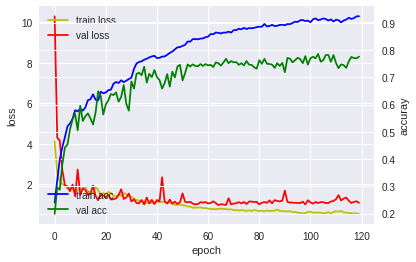

In [0]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [0]:
data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAaAAAAEGCAYAAAAjc0GqAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMS4yLCBo%0AdHRwOi8vbWF0cGxvdGxpYi5vcmcvNQv5yAAAIABJREFUeJzsnXd4FFUXh9+tySYhISEJHULLpXcF%0ARHpvnyJVQKWpiPjZFREFEUQ/RRQLTaqAWJDeu1QpoUOGGhKSAOm9bJnvj0kWQgKEkMYy7/PsQ3bm%0Azp1zd5f97Tn33HM1siyjoqKioqJS2GiL2gAVFRUVlccTVYBUVFRUVIoEVYBUVFRUVIoEVYBUVFRU%0AVIoEVYBUVFRUVIoEfVEbcC8iIhIeKkXP09OFmJjk/DKnSFHHUjxRx1I8caSxwIOPx8enhKYAzck3%0AHNoD0ut1RW1CvqGOpXiijqV44khjAccbTyYOLUAqKioqKsUXVYBUVFRUVIoEVYBUVFRUVIoEVYBU%0AVFRUVIoEVYBUVFRUVIoEVYBUVFRUVIoEVYBUVFRUVIqEYr0QNc9YLLh8/QW8MgJKlS9qa1RUVFTu%0Ay40bGpYvNxAVpSExEVq0sNKvn6WozSpQHNID0p87g+v0b2D+/ALpf9eu7blu+/330wgLC71vu4CA%0AI4wf/8HDmKWiolLMSUgAyx2aIsvw5596WrVyZcoUJ2bNMrJkiZFffzUUjZGFiEMKkKzJGFZqar73%0AHR4exrZtm3Pd/s0336VcOdULU1EpSiRJy5IlBq5fz7lCzfHjWpYuNXDqlDabQOQHsgzz5xuoW9eN%0AJ590Zd48A5GRGv76S0/fviZef91EejpMnpzK1q1JHDiQyJ9/puS/IcUMxwzBGTJ+OZjN+d71t99+%0AxblzZ1iwYC42m42wsFDCw8P47rufmTp1EhERN0lJSWH48Fdo2bIVY8a8wjvvfMDOndtJSkokOPgq%0AoaHX+O9/36VFi5Y53mP79q38/vtSdDodQtTirbfe4+zZs4wf/ykGgwGj0chnn00lPDyUadO+ynKs%0ARIkS+T5mFZVHlb//1vPTT0ZOnVJK2bi7y3z2WRqDBpmJiYHDh3XMnm1k795bX4WurjL9+5sZOzYN%0AT09IS4MNG/T4+dlo1Mhmb5eUBAkJGsqUuXfJypAQDWPHOrN1qx4PD5nISA0ffeTMRx/datO6tYVp%0A01KpXPnx2qG6QAVICFEXWA1MlyTpRyFEReBXQAeEAy9IkpSW1/6vXx9PfPyq7CesZrS/AW5LsJ3f%0A8EB9urs/S5kyk+96/vnnX+Dvv/9g2LCXmTdvNhaLmZ9//oWYmGiefLI53br1JDT0Gp98MpaWLVtl%0AufbmzRt8880MDh7cz+rVK3IUoOTkZObM+YkFC5bh4uLCBx+8TUDAEQ4f3kfv3n3p2rUHR48eJjo6%0Aig0b1mY7pgqQiqOycaOetWv1REVpiI3VUKeOlQEDLDz5pJWkJAgK0lKpkg13d6X96tV6Ro0yodfL%0AdOlioV49K7NmGXn7bWcmTHAiPv6WN9SmjYWuXS2cPq1lzx49CxYYWb1az7PPWlizRk9kpBa9Xmby%0A5DSGDTOzbp2e995zJiZGQ5kyNpo0sfLee+nUqaMIlM0GK1fqWbbMwN69OmRZQ5s2Fn74IRWdDmbP%0ANnDwoI7Wra307m2hRg1bTkN2eApMgIQQrsAPwO0TJpOAnyRJ+lMI8QUwHJiZ/3fP+GDJBf9rolat%0AOgCUKOHOuXNnWLPmbzQaLfHxcdna1q/fEABfX18SExNz7C8kJJgKFSrh4uICQKNGTTh/PpAOHTow%0AfvynhIQE06FDJypX9uPpp9vwzTdfZjmmouIIpKZCVJQGb2+ZxEQNH33kxKpVt+ZE9HqZY8d0LFli%0AxM1NaQPg5WVj0qQ0GjWCMWOccXOTWbs22S4Mgweb+fhjJ06f1tGsmZWaNa0884yF+vVvCYDZnMbc%0AuQa+/tqJ+fONuLvLDB+ezpo1esaOdWbZMgMnT+owmWQ6dbJw8qSW9esN7NypZ9asFJo0sfHGG87s%0A2KF8vTZvbmHIEDN9+1rQZswOjB+fXkiv5N0RQkwHmgMy8KYkSYdvO/cMMB5IA5ZLkvRjQdhQkB5Q%0AGtAd+PC2Y22BURl/rwXe4yEEqEyZyTl6K9rr4ZRqK2BgLyJmzMlr97nCkBHu27p1E/Hx8fz00y/E%0Ax8czcuQL2drqdLcq2sp3EUeNJus5i8WMk5MTLVq04JdfFrN//x4mT57ImDFv0bTpk9mONW7cNB9H%0Ap6JSuMTFwbx5RubMMRAdrXxb6/UyFouGpk2tfPVVKtWq2XBygr17dSxfbuD4cR1Nm1opW1Zm9Wo9%0AY8aY0OuV35+LF6fYxQegfHmZhQvvPTdsMMDo0Waee87CiRNaWra04uYGY8ak89JLJk6e1FG/vpWZ%0AM1PtnsvatXrGjHHmpZdMlCwJMTEa2re3MHVqKlWqFL+wmhCiDVBDkqQWQohawHygRcY5LfAj0BiI%0AAjYKIVZJknQtv+0oMAGSJMkCWIQQtx92vS3kdhMoe68+PD1d8laGXJNxi/R0fHzyNyTl5eWGTqfB%0Ax6cErq5OuLk54+NTAoslherVq1C6tAe7dm3CarXg41MCo1GPp6drlrYxMa4YjfostpUs6YKTk4FG%0AjeoQHn4Nk0mDm5sbZ86c4LXXXmPJkiW0adOGwYP74+bmRFhYEBERodmOdenSLl/HW1Dk9/tSlKhj%0AeXiiomD6dPjhB4iPB09P6NcPoqMhNlbD88/DW2/p0Olc7df07as8FBSxCgqC116DzZth9mwN/fu7%0A5NkmHx+oVy/r84MH4Z9/oH17HUbjLVuGD4eGDaFXL7h5E77+Gt55R49W65bn+2e3J1/fmw7AKgBJ%0Aks4JITyFEO6SJMUD3kCsJEkRAEKI7UBHYGF+GgCgudsv8fxCCDERiMyYA7opSZJvxvHqwGJJkp66%0A27UWi1V21H0wVFSKO7/+Cl99BT//DK1b560Pm03xamw2KFVKORYTo4jNihXg5gZeXrB3LyQmgq8v%0AvPuuIiJ5nc6UZeWeJUvm7fqHIS4OYmOhcuXCv/cd3HNDOiHEHGC9JEmrM57vAUZIknReCKEBrgCd%0AgCBgDbBLkqSv8tvIws6CSxRCmCRJSgHKA2H3apznHQ1TUvCpXBq6diVi8R9566OY4eNTgoiIhKI2%0AI19Qx1I8uX0sW7fqGDbMhNWqoVs3mSVLUnj6aSsAycnwxx8G5s83kJKiYcSIdIYMMePmpqxxOXZM%0Ay8qVBjZs0BMerkGWle/C8uVt1K1rY/9+HQkJGkwmGYsFzGYNvr42PvwwnRdeMOPioswBPcwqiqJ8%0AX1xcICIif/t80PHkwVuyC5YkSbIQ4iWUsFwcihgVyA6rhS1A24A+wJKMfzcVyF0y07DTi36iT0Wl%0AuCPLEB6u4eJFsFq13LihYeRIE0YjvP12Gt98Y2TwYBNDhpi5eFHL0aM64uM1GI0yej18+qkzX3/t%0AhJOTTFTULcHx9JRp1sxKyZLKHM7x41o2b9ZTqpSNCRPSGDpUEZvERDCZQO+Yi0KKK2FAmduel0PJ%0ATAZAkqTdQCsAIcRUFE8o3ynILLgmwDTADzALIfoCg4GFQohXgavAogK5eeZkfwGsA1JRedSxWODM%0AGS179+o4cEDPsWNaIiIy16Qr8xparcyiRSl06WKlbl0rw4aZmDvXCEClSjZefjmdoUPNGAwy8+cb%0AWb7cgF4P1atbqVrVRq9eFlq3ttp/C4IidNevayhZUsZkunVcXTlQJGwBPgNmCyEaA2GSJNldLCHE%0ARuAlIAnohfJdnu8U+BzQwxARkZBn47wreKNp1IiItVvz06Qiw1FDPY86RTWWpCTFY3ByUr7YN2zQ%0A8+WXRrRaGDnSTO/eZg4d0rFihYHQUA3u7jIuLnDlipZz57Skpt6KqFSoYKNePSt16hiIiEgnIUHD%0AM89Y6NbtVkmAq1c1XLumpXZtK56ehT7cB8aRPmOQpxDcfUNmQogvgdaADXgdaATESZK0UgjxHPAp%0ASor2N5IkLc2T4ffBcQXIryyamoKITbvy0aKiw5H+Q6ljyTvR0fD9907Mn6+4Fo0bK/MyBw7o0etl%0ANBplTkWrlbHZsn8HGY0yQtho0MDKU09ZadlSSV8uirEUJI40FigYASoOOGzUVTYa0KghOJVHnMhI%0ADRMmOBEaqsFqhbNnlQn88uVteHnJHDyorLJv397C5MmpuLnBL78Y2LpVT/PmVvr2NdOokY2EBEhM%0AVMrGGBy/xqXKI4LDChB6g5qEoPJIIcsQHKyhXDlFJK5f19C3r4nz528tRfD1tfHBB2m89JIZZ2cl%0A7TcyUkPVqor3A8oq+ztX2nt6KkkBKirFCYcVINlgKPIkhL59e7F48e/2sjp3O6bimJw8qSUhQUPZ%0AsjbKls068R4XpxTCBCVpMyBAx++/G7h8WYu3t41nnrGwfbueoCAto0alM2FCGroclsR5eICHhyos%0AKo8mDitAGIxFLkAqjydRURrGj3dixYpbsS6tVqZePRvNmlkJCdGwfbue9PSsYfrM2mLHjmmZN0/J%0AOHvnnTQ+/DDd7t2oqDgSDitAskEPifm/n8bw4YP54otplClThuvXwxk37n1++GEWn302npSUFFJT%0AU3n77fepXbvuPfu5efMGU6dOwmw2o9VqGTv2E3x9SzNp0idERUWSnp7OiBGv0rTpk0ya9Anx8TEk%0AJaUwYsSrNG9+1+IRKkVAcLBSbj8+Xll9HxCgJTJSS8OGVtq1sxAeruXSJS0nTmg5cUJxY2rVstK9%0AuwUXFyVSXK6cjZ49LZQoofxu2r1bR1qahh49HHtHTJXHm0dagFwnjsdpbQ7bMQDa8HCwWfFqcm8h%0AuJO0Xs+SNPHu2zG0bt2Offv+oU+f/uzZs5u2bdsTFRVFz57P0rp1W44ePczSpYuYMuXre97nl19m%0A0bPnM3To0JmdO7cxf/4c+vV7nri4WH76aS4JCQkcOLCPS5cuEhcXy7JlS7l8OYwDB/Y90HhUCpbL%0Al+HZZ124dk1rzzwzmWQmTEjl1VfNWRZXpqTAiRM6PD2VTLS7YTBAx47WQrBeRaVoccgdUQGlcEQB%0ApJgrArQHgL17d9O2bQe8vEqxe/d2XnttBDNn/kBcXPatGO5Eks7RqFETABo3bsqFCxKVK/uRnJzE%0A559/QkDAYTp27Gw/9v7779uPqRQ9NptScqZNG7h2Tcv48WmEhydy6VIC584l8vrr5mwr+00maN7c%0Aek/xUVF5nHikPaCkiZPv6q2U7NoOw5nTRB89na/3rFq1GlFREdy4cZ2EhAQqVarM/Plz8Pb25ZNP%0APicw8Cw//vhdLnrS2LddMJstaDRanJ2dmT17IadOnWTjxrXs27eHceMmMHv2QkJCLvDbb3/Yj6kU%0APrKshMYWLDBw8KCemBhlYubTT1MZM0aZb1RX9auo5J5HWoDuSQEmIbRo8TRz5vxMq1ZtAIiLi6Va%0AtRoA7N69E0suNpWvVas2AQFH6NSpK8ePH6VmzVpIUiBBQZfp0qU7derUZfTokfZjQ4YMoHz5aowe%0APbJAxqSSncREOH5cR0SEhogIDStWGDh2TJnDqVTJRqdOFgYNMvDUU2qyi4pKXnBYAZINBiVOYrWS%0AY/7qQ9CmTTtGjRrOwoW/AdC1aw8mT57Azp3b6NOnP9u2bWH9+jX37GPkyFFMnfo5a9euQq838NFH%0An+Dk5Mzs2T+xevXfaLVaBg16gbJlyzF79k9s2LAaq1Vm0KDsG92p5I3YWBg71pmgIC0WC2i14O0t%0A4+0tc/myhoAAHRZL1vSzHj3MvPlmOg0bKmE0Hx9Dvlc+VlF5XHDYUjwe/Z/FuGsHEcE3wdk5H60q%0AGhyptEhxGEtsLPTv78Lx4zqcnJSqzlYr9hppWq1Mo0Y2nnrKQrlyiijVrWulWrWsH8niMJb8Qh1L%0A8UUtxfOIIRuVdRQaczqyAwiQysOROX8TG6sU5vzySyeOH9cxaFA6336bhlartElKgps3NXh5yUWy%0AoZmKyuOEwwoQ+oxFgOpiVBVg5kwDEydm/SFyu/gAaDTKDp1ubsU3KqCi4kg4rADJxkwBUhfyPe4c%0APKjj88+d8PW18fbb6cTFafD1lRk0yGwXHxUVlcLHYQUo0wPSmNNRf88+vty8qeHllxXPZ+7cVFq0%0AUBd4qqgUFxz2959sUENwjzORkRp++MFIt24u3LihZdy4dFV8VFSKGY7rARkykxBUAXqckCQts2YZ%0A+PNPA+npSlmc115LZ8wYdWsOFZXihgMLUMbQVAFyaEJDNcyfbyAoSEtw8K1in1Wq2BgxIo3+/c1q%0ANpuKSjHFYQVIzvSALKoAOSr79ukYOdKZqCglkmw0yjRrZmHUKDNdu1rye/2xiopDIYSYDjQHZOBN%0ASZIO33budWAIYAWOSJL0VkHY4LBzQPZ9h9VdUR0OWYa5cw307WsiLk7DlCmpnDqVSHBwImvXptCj%0Ahyo+Kir3QgjRBqghSVILYAQw47Zz7sD7QCtJkp4GagshmheEHQ4rQHJGCE6Ti7psKo8O6enw3ntO%0AfPyxM15eMn//ncLLL5spXVpWU6pVVHJPB2AVgCRJ5wDPDOEBSM94uAkh9IALEF0QRhTrUjwWi1XW%0A69WfsioKEREwYADs3AmNGsHq1VCxYlFbpaJSLLlnKR4hxBxgvSRJqzOe7wFGSJJ0PuP5YOAHIAVY%0ALknSuwVhZLGeA4qJSc7ztaYZ3+I2eSJxv/1FeodHfw8dR6pt9aBjSU6GuXONzJhhJCFBQ/fuZn76%0AKRVnZ4q8EOjj/L4UZxxpLJCnWnAPegu7YGV4QuMAfyAe2CGEaCBJ0okH7fR+FGsBeij0aiUER2Dv%0AXh1vvOFMaKgWLy8bU6akMWKEWsFAReUhCQPK3Pa8HBCe8Xct4LIkSZFg946aAPkuQA773/hWKR41%0ACeFRxGyGKVOM9Olj4vp1DW+8kcahQ0m8/LIqPioPx8T943lhwwCK8/RDIbAF6AsghGgMhEmSlOli%0ABQG1hBCmjOdNgQsFYYTDe0DqQtTigSwrxT5zw6lTWt56y5lTp3RUrmxj1qwUmjRRt7FWeXj+DT/I%0Az8eVhK9jN4/SuHTTLOdTLakM3zSEkIRgALxMpVjQdQlezqUAOBN5mk/3j+O7dj9SsUSlwjU+H5Ek%0Aab8Q4qgQYj9gA14XQgwF4iRJWimE+BrYKYSwAPslSdpTEHY4rgBlbMegLkQtGhITYc0aPXv26Dl8%0AWEd0tIZJk9IYMiT7+xEcrOHECR2JiXDunI5ffjFgsWgYONDMlCmp6jbXKnfl8PV/WXp2MV+0+hoX%0Ag0u287GpMQCUdPbEarPy0Z737OdWX1yZTYCWnlvEtuAtuBlKoNFokGIC+T3wN15rOAaAGQHT2HNt%0AF4vPLODj5hMKbFyJ5kRsNivuTh4Fdg9JksbecejEbedmA7ML7OYZOGwwQ9ZnpGGrAlSonD+v5d13%0AnahXz4233jKxYoWBhAQNWi28844zX35pRJaVzd+OH9fy6qvOPPmkKyNGmHjzTROzZhkpU0Zm+fJk%0AZsxQxUcFks3Jdw2XfXFwEssCf2Vz0IYsx22yjQWnf6HJkno0XVKfxWcWsPjsAk5HnqR39T64Gz1Y%0Ac2llln7TrGnMCJiOi96FQ0NOcGjwCQxaA8sDlyDLMnFpsWy4sg6AdZdXP1QIb83FlbRY1pgvDk4i%0ALDHUflyWZZad+5VGi2vTb+0zee7/UcFxPSC1GGmhcvGihm++cWLlSj2yrKF8eRtjxqTTq5eF6tVt%0ABAVpGDjQhW+/dWLZMoiIcMNqVWJytWtb6dfPTKlSMu7u0Lq1BTe3Ih5QISPLMprcxigdgOM3Axi/%0AdyxVPKrSqHQTulfpSRnXstna/XX+d97cMZqGvo35pPlnNC/3lP3ctYQQ9oUpkaHNQRvpXaMvADeS%0Ab9B7wVD2hezD3eiBjMx7u99EgwY3QwkmtZyKQWfkD+k3jt44TNMyTwKw7NyvhCeFMbrhf/E2eQPQ%0A2a8b6y+v4VTkCY7dDCDNmoaTzolLsRcJjD5HrVK1H3jssakxfPjPO0SlRvFdwDf8cGw6DXwaUtat%0APBHJNzl0/SBuhhK8Un/0A/f9qOG4HpDh1o6oKgVDUhL89pueZ5818dRTbvz9t4HatW0sWJDCkSNJ%0AvPtuOv7+NrRaqFpVZv36ZNq1U6oUNG5s47nnzCxfnszOncm8/rqZgQMtdO/+eImP2WrmhQ0D6Lv2%0AGSy24pWxueL8H9Sc78epyJMF0veh6wf5XVrG2H/epdOfbYhJzbrW8dezC3l92yvoNDoOX/+X/6zq%0AyrBNQzBblR+Vf1/40952e/BW+/FvDn/JvpB99Kj6H/Y9f5i9Aw/RrUpPZGTGPvkxpV3L8Ey13gCs%0AvrQSgHRrOjMCvsWkNzG64X/t/T5fczAAywOXsjxwKVqNlo+afQrA+str8jT2rw9PJSo1ivef+Ijp%0AbX+krnd9TkWeZP3lNRy6fpAuft3YM/Bf+vj3z1P/jxIOK0C3PKDi9Z/aUdi2TUerVq68+aaJ/fv1%0AtGxpYf78FLZvT75rKRwfH5nff0/h2jVYvz6ZWbNSad/emuvkBEfkmyNT2Ry0kT3XdrHozLwis+P4%0AzQA+2vYRqZZUAFIsKXx24BOiU6OZfCD/5zrORp0BYHOfnbxcbxQ3kq8zbs8HgOINzjrxI+/u+i9e%0Azl6s77ONjX2207T0k6y/vIaZJ35ElmX+lJZj1BrpU6M/cWmx/Hv9AInpCfx1/ncqulfkl86LKO1a%0AhrJu5VjUbRmnhl7glQaKV9GmYnvcjR6svbgKs9XM9KNfE5p4jRfrDMfXxdduZ7uKHfEx+bLs3BKO%0A3jhM24rteaH2Sxi1RtblQYDORZ1l/um5VPWoxn8bv8Pg2i+ytd9uQl6N4PTQixwafILF3ZZTvkSF%0AfHiViz+FGoITQrgBiwFPwAn4TJKkzQVxL/t+QGox0nwjMRH279fxxx8G1qwxoNfLjBmTxtChZipV%0AeqxTWvPEvtA9fHd0GpVKVCY2LZYvD03h2ep9KelUki8PTeZU5AneavI+zcu2eKB+z0adYfKBCXzU%0A/FPqedfP1TVT//2cnSHbiU6IY/LTX7Hg9C9cTwrHSefEzpDtHAjbR4tyLfMyzGzIssyZqFP4uVeh%0AUekm1PNpwNEbh1lx4Q+6V+3FvtB/mH96LqVdyvDXf9YgvGoCsKzHnzz1W1OmHfmSqh7VkGIC6Vn1%0AGfqJgay48AebgzZyMeYCSeZExj79ITpt1l9BpV1K2/826ox0r9qT5YFLeWJJfcKSQinpVJIxDd/M%0Aco1BZ6Cv/wBmnvgBgIFiMCWM7rSp2I6tVzdzOe4SVT2q5Xrc4/d+iFW2MvnpL3HSOdnPaTXaLML3%0AuFDYHtBQQJIkqR1KDvr3BXanDAHSqMVIH5rLlzUMHeqMv78bQ4a4sGaNgSZNrGzblsynn6ar4nMX%0A1l1aw5agjXav4naiU6MYve1ltBotMzv9wgdPfERcWiwT9o/jxY0D+T5gGjuCt/GflV0YtK4v4/a8%0Az7BNQ3hrx+v2zK6csMk23t75OtuCtzBi0wskpt9/9XxiegL7QpW5lDknZ7LqwgpmBEyjhNGdhV2X%0AAvDFv5Pybd3MjeTrRKdGU7tUXQD0Wj0z2s/CSefEyM0vMv/0XGp51WFjn+128QElk23y01+SYknh%0A1a3DAOjrP4CW5VvhanBj85UNLDozH51Gx4hGI+5rx7PVn7Pb82Lt4ewecJDSrmWytRtQcxAAHk4l%0A6VqlBwA9qyoJAusu5d4LCrh5hD2hu+lQqRMdK3fJ9XWOTGELUCRQKuNvz4znBYPqAT006ekwYYIT%0ArVq5smGDgZo1bbz9dhorVyazbl0ytWura3Puxp5ruxm+eQhDNgyg1oKqvLZ1JFEpUYAiEqO3vUx4%0AUhjvP/ERT5RpxrC6LyM8a/KH9Btbr26mbcX2/NlrNU+Ve5ptwVv45dRs1l9ew7LAXxm0vh9J5iQA%0AdofsZNye97mRdB2A3wOXcexmAN4mb4LirzD2trTju7EzZAfptnSeq/UcTjonXtk6jOjUaF5v+F86%0AVO5MV7/u/Bt+gC1XN91XhPaH7mXaka/s8zEAc0/OpN3vLe1zPGejTgNQu1Qdext/L8HYJz9BRqZD%0ApU6se24zFUpkL/TXu3pf2lZsj9lmxtPJk46VO+Okc6J9pY4ExV/hTNQpulXpSdkS2RMa7qRdxY7M%0A6/Ire58/xDdtv6OsW7kc29UuVYf3n/iIKU9/hbNe2d69S5Vu6DS6bJl092Lp2cUAj0VyQa6RZblQ%0AH/7+/pv8/f0v+vv7R/n7+ze/V1uz2SLnmYMHZRlk+YMP8t7HY84XXygvoZ+fLP/1lyzbbEVtUd6x%0A2qzyz4d+lk/fOG0/lm5Jl7/d/6289dLWHK9ZdW6V3HpBa3n9+fX2Y5svbpZbzmspf7nnSzkpPcl+%0A3Hbbi2O1WeVGsxrJTER+de2rctXvq8pMRK7zUx05PCFcnrBzgsxE5C6/dpEt1luf8Z1XdsouU1zk%0A0etGy2ar2d5vQFiAfDTsqByeEC4PWjFIZiJyx8Ud5ZdWviQzEZmJyBW/rSj/E/SP7Pu1r+wyxUW+%0AHH1ZfmLOEzITkacfmC5LkVIWe2/nxZUvykxEPhx6WP7+4PcyE5G9/+ctx6fGy7Isyyeun5A1EzUy%0AE5FdprjI4gchD/xroPzt/m/lC1EX7P3EpsTK3v/zlpmIPGjFINlqs8p/nP7DbuPi44tlWZblr/Z+%0AJTMRecXZFVnssNls8pmbZ7K8JjlxMeqi7Pmlp/zh1g/txxYdX2S/z7ZL2+55fX7xzG/PZLvfzis7%0A5al7psonr5/M8pmIT42XXae4ypWnV5atNmthmFfo3+15eRRqNWwhxBCgtSRJrwghGgDzJElqerf2%0AEREJeTZOf/I4nh1bk/zqaJI+/zKv3RQbCru4YmoqNGniSmqqhoCARDzycT1cQYzlYNh+xu39AH9P%0Af2Z1mp/t/OagjbywYQCuBjfmdJrPk2WbM3zzi+y5tguAfv4DmdRyKqVMpZBlmZknfuSz/eORUT6C%0AYxq9hUGr57uj0+zHyriWpZfoyeGQI1yIvUA//wFMefp/rLq4gte3v0KfGv2Z2ekXe+x/7qlZlHMt%0AT1hSKJVKVGZrv914OntlsdM9T8iYAAAgAElEQVRsNWPQGe46TrPVzPDNQ9gctBGAet4NaFWhjX11%0AP8C4Zp/yVpP3uBx3iQ5/tCLJnAiATqPjnaYf8F7TsfaUb6vNSp2F1TBojYS9F0pkRCI/HJtOPe8G%0AtKvUwd7n8sClrLu0mrCkMEISgolLiwXARe/Kpr47qOlViykHP+P7gGmUdCpJbFos3av0YkfwVmyy%0AjXRbOn39B/Bzx7m8tnUkKy78wb+Dj1PFo+oDvc+ZpFvTMWgN9nFEpURRb1ENKrv7se/5I5T29Sjw%0A/y/HbwbQ+a+2tCjXktXPbuRaQghtfm9BQno8AFU8qjK55Zd08uvK0rOLeXvXGD54YhzvPXHn+s/7%0Ak4dipI9Eak9hrwNqCWwGkCTphBCinBBCJ0mSNb9vdCsNWw3B5YU//zQQEaFlzJi0u4qPTbZhk23o%0AtUW3nCzVksr4vWNZfFYRHSn6HD92sGSzaUvQpoz2KbywcSDlXMtzLTGEjpU6E5kSwZ/nl7P+8lr8%0APKpg0jtz9MYRyriWZUKLz/nf4S/48dh3AFRy9+PbtjPYc203c07+zNyAuRi1RtydPFh4Zh6X4i5x%0AOfYiTjonxjVX0nU1Gg2Tn/4KF4Mr3wdMw0nnxPyuv2YTH+Ce4pN5fm7nRXx2YDyV3f0YWW8Ueq2e%0Axr5NGLP9Vcq5lWdUA2XVflWPaqx5diPrr6zlemI4u6/t5OvDU0lMT2TiU5PRaDQcvnGI6NRoXqg9%0ADK1Gi0aj4b+N38l234E1BzMwIyVZlmWuxF9m4+X1fHZgPMM2DWZB16XMPvETZV3LsaXvLgau68OG%0AK2vRarQs6f47b+98g10hO7DJNs5GncFF70pld78HeKezYtQZszwvZSrFn71W4+tSGq2mcGYWGvo2%0ApmOlzmwL3sLe0H/4/ug0EtLjebX+aMKTwtkctIFhm4awtMefLDm3CK1Gy/M1hxSKbY8Khf3NcRFo%0ABqwQQlQGEgtCfAB1IepDYLXCzz8bMRhkXnnl7q/fx3s/YN2lNRwacgKT3nTXdgXJgtO/sPjsfGp5%0A1cbDqSQHw/cTFHeF6p417G1kWWb71S14OnmytMefDN00mGuJIbzW4A0+bTEJGZlfTs1i6dnFBMdf%0AJdGcQEOfRizq9htl3crR2a8rE/d/gtVm4bOWU/BwKknrCm15tcHrJOujKa2tjNlmZvTWkWzKWJH/%0AesM3s9QK02g0fNx8AnVK1aW0axnq+zTM85id9c5MbfVNlmP/qd6bZmVbYNQZ7fMUAPV8GlDPpwEA%0A4Ylh9F3zH2ae+IGE9HgmPjWZLRmeVBe/rrm+v0ajoapHNV5v9F8iUm7y8/EZdP2rPanWVD5q9gml%0AXcvwe6+VfLD7bbpX7UnHyl1oW7E9v0vLOHbzKBdiJRr4NMp3oWhZvlW+9pcb3n3iQ7YFb+HlzS8R%0AlRpFx0qdmdRyKhqNhj3XdjNofV9e2DCAVGsqHSt1fmzSq3NLYQvQbGC+EGJ3xr1HFdSN1FI8eWfT%0AJj2XLmkZNCidMmVyjoKarWb+lH4nPj2OizHn7V9yhc2+0H8A+L3XSv46/wcHw/cjxQRmEaAzUacJ%0ASwrluRr9aFrmSXb038fluEtZ0ptHNRhj9xwSzYm46l3t4Z0SRnemtc2esOlt8sbHpwoREQk46ZxY%0A0HUpXx2awuHr//JmDl4EwLM1+uTb2O8kpwyu2ynrVo5Vz26k/9pnWXJuUYaHosOkN9GqQts83XN8%0A84mcuHmMfWF7qFOqHv38BwLg6+LLwm5L7e0yBWjuyZlYbBZ7BtyjTpPST9CuYgd2hmzH3ejBtLYz%0A7J+bVhXaMKfzQoZvUryewbVfKkpTiyWFKkCSJCUChbO8Vy1Gmmd+/ll57UaPvvtrdzB8P/HpcQBI%0AMYFFIkA22cah6wep7O5HGdeyCE8BwPnoQHpU7WVvt+2qstSsU0bqq6+L7z3XXLgZ8laKQafV2cNu%0AxRUfFx/WPbeFuSdn8sOx70hIj6ZrlR559mD1Wj1zOi/k68Nf8FKdEdnW3mTSpmJ7QCkAClDH2zEE%0ACJQ5t1ORJ/ni6f9ly6TrVqUHi7ot40DYfjpXzr2X+bjgsLXgZL0agssLoaEaDh/W0bq1BX//u6dZ%0AZ4ZuAC7ESPfsM+DGESYfnMiPHWZTzq18vtl6PkYiNi2WLn7dAfDPWDMixQRmabf16ma0Gi3tK3XM%0At3s/yrgaXHmryXu8WGcYK87/QaeH/GL0cfHhf22m37ONt8mb+j4NORlxHMBhPCCABr6NODvs0l3P%0Ad/brRme/boVo0aODA5fiUUNweWHrVuV169bt7iWMZFlmU9AGjFrFU5Ki7y1A3wd8y97Qf1h4+uFK%0AzVhsFvt6F4B/ww8A0CwjlFaxRCVMehPnbxPE6NQojt44zBNlmuU46f844+Vcipfrv4afR5VCuV+7%0Airey6mp7PXgRTxXHw2EFKDMLTt0R9cHYskURoE6dsgpQujWdFEsKoHgeV+OD6FqlB+5Gj3t6QNGp%0AUfYQ2IoLf2CT87549adj39Po19qcuHkMyC5AWo2WGp6CizHnsdqU3JYdwduwyTZ7+E2l6GibEYar%0AWKJSge5zo/Lo4LACZC/Fo3pAuSYpCfbs0VGrltVeXudaQgifH5hAvYU1aLa0IYHR5+xrULr4daOG%0Apz9X4i+Tbr0l9LevLVtzcRVmmxk3QwlCEoI5FH4wz/YdDN+PxWaxr3n5N/wAXs5eVC95K+HA31OQ%0Aak0lOOEqcGv+Ry19UvQ8UaYZfu5V6Fi5c1GbolJMcHgBwqJWw84te/boSEvT2L2fUxEnaLa0IT8c%0Am46MzPWkcJ5d1Y3fAn9Fq9HSoXInhGdNLDYLV+IuAzDv1BzqLKzO6chTgLKfiwYNU1t9DcCf55fn%0AypbNQRv5eM8HWTymwOhzAKy5tIp/ww8SkhDMk2VbZNlHR3hmzANFB5JsTmZz0CYquftRSw35FDlG%0AnZF/Bx/nq9bfFrUpKsUExxUgrRZ0OrUY6QOQGX7r3FkRoM1BGzHbzHzwxDhOvnSe6W1/JCY1hkux%0AF2lWtgVezqWokZl5lhGGW3puMZEpEQzbNJiTEcc5dP0gT1doQ1//AZRxLcvqiytzLM55J1P//Zy5%0Ap2bZRSc+LY7QxGs465yxylbe3PEaAM3KZK0ULbxqZdgTyLarm0kyJ9K7ep/HarO34oz6PhQfhBDT%0AhRAHhBD7hRBP3Ha8vBBi122PYCHEoIKwwXEFCBQvSC1GmitsNiUBoVQpG02aKF5H5pf/8zWH4Kx3%0AZnDtF/m541ycdE70938eAOGVKUCBhCeGcTryJCa9iavxQTy3WkmF7uc/AJ1Wx3M1+hGfHsf68+vv%0AaUt4Ypi9YGXmfE9mZtugWi/g61Kay3FK1lGzss2zXOufYY8UHcjfF/4CsO+UqaKioiCEaAPUkCSp%0ABTACsNdykiQpVJKktpIktQU6AsFA3nbfuw+OLUBGo7ohXS45eVLLjRtaOnSw2jeTOxd1BnejR5bU%0A6T7+/bk0MpTBtV8EsHtAF2IktgVvAWDsk5/QpkI74tPjMOlN9jU5mYsUfzn2yz0rCO8I3mb/+3hE%0AAHBLDOv7NGRE3VcAcNY5Z6soULmEH046J47eOMz24C3U9KqVpeqyiooKAB2AVQCSJJ0DPIUQ7jm0%0AGwqsyFjDme8U63VAnp4u6PU5L2zLFXFxGACffLOoaPHxKZHvfcoyrFgB72Qs3B8wwICPj4FUS6pS%0ALaBCc3x9c/pcKpTyroNJb+JS/AWsWsXbfL5xX0a3fJmOizvSsWpHqpZXBKytTwueqvgUmy5uYnGV%0AObz3VM5bBey9sRMADRpOR5/Ax6cEV5MvAtCiWlOqeVbj5xMzaFmpJeXLlMp2fU3vmpy4cQKAIQ0G%0AF8jrdjsF3X9hoo6l+JLP4ykDHL3teUTGsfg72o0ECixrpFgLUExM8kNd79NAYDG5EHPwWD5ZVHQU%0ARAXpCxe0jBvnxO7deoxGmXfeSadly3QiIuB05CmsspXq7jXve9/qJf2RIiUuRF2kqkc1StrKICfB%0A1j7KJme3Xz+z3Xy6rWzPB1s/wFtXLkvFAlBK/Gy5tJVKJSrj6ezFiesnCL0exbGwk8rroKmILcnI%0A7gEHcTW45mhbNfcadgHqVK5ngVZFLuwq5QWJOpbiSx6qYT/oLbJNzgkhWgCBkiTdKUr5hmOH4AyG%0Axz4Ne+9eHT//bCAt7daxxET4/HMjbdu6sHu3nnbtLPzzTxJjx6ajzfhEnIs6A0DNjEn9e1HD059U%0AayrJlqT7rrcp61aOdc+vw6R3YfS2kfbQWiZHbxwmIT2e9pU60tC3Mem2dAKjzxIYdZZKJSrby+SU%0AcyuPh1PJHO/hn5EJ19i3SZ7L/auoODhhKB5PJuWA8Dva9AS2UYA4vAA9zqV4duzQMXCgiYkTnena%0A1YXz57X8/beeli1d+eEHJ0qXllmwIIXly1MoXTGRncHb7XMzmcKQm/mTzNRnyN16m0ZlG/Ftuxmk%0AWFJYcnZhlnPbg7cC0KFyZxr6NFLGEbyNiJSbuRJDgKZlngRgoFr6XkXlbmwB+gIIIRoDYZIk3eli%0APQGcKEgjHFuAjEY0j0kW3I0bGkaNcqZ3bxO//mpg+3Ydw4aZ0GigVy8zZ87oaNXKhVGjTERHa3j7%0A7TT27k2iRw8LGg0sPrOAAet6s+7yauBBPSAlEcHV4EaLci1zZW/Pqs9QwujOpqCNWRIStgdvxag1%0A8nT51jTwVQTod2lZhi25W8vTukJb9j1/hJfqDM9VexWVxw1JkvYDR4UQ+1Ey4F4XQgwVQvS+rVlZ%0A4GZB2lGs54AeGoMB0h1fgFat0vPhh87ExChh3H37lLdVr5dZtCiFTp2srFtnYdw4Jxo3tjBxYhp+%0Aflmz0EIyKgf8HriMXtWeJTD6HGVcy+aqflptb8VLal+pY7aNwu6GUWekfcWOrL70N1JMIDW9anE9%0AKZzTkSdpXaEdrgZXhGdNnHXOXIpVEhCEV8379HqLGp7+uW6rovI4IknSnVuznrjjfL2CtsGxPSCD%0AweE9oDVr9Lzyiom0NJg6NZWAgEQ+/DCNJk2szJmTSqdOSk20nj0tnDyZxMKFqdnEByAiOQKAHSHb%0AuBJ3mWuJIbkOeVX1qMbynn/zRUa1g9zSOWMTtM1XlE3cFp1RdjXtVqUHoOz+Wde7vr19zVJqNQMV%0AFUfCsQXIaAQHroQgy/Djj0Y0GpkNG5IZMcJMhQoy776bzsaNyfTseWsNVIolhRc3DLTXcbuTyBRF%0AgCw2C18dmgxALa/cr59pX6kjpV1KP5D9HSt3RqfRsTloI4nmROadmo2Xs5d962eAhhlhOK1GS42S%0AqlejouJIOLYAGQxoLBblm9oBOXpUy/HjOrp0sVC79r2rTB8M28+moA0sD1ya4/mIlJuY9Ca0Gq29%0AgkCtAvY4PJ29eLJsc47eOMx3R74hNi2WkfVG4WpwtbdpkJGIUMWjapatplVUVB59HFuAMndFddCC%0ApL/8ooxv5Mj7hxkDbh4BICjuSo7nI1MiqFSiMq1v25q5MAp4dvHrjozMjGPf4qJ3ZXi9l7Ocb1y6%0AKeBYG5ipqKgoOLYAZVbEdsAw3I0bGtau1SOElVatrPdtf+yGsuj5anxQtjI4ZquZ6NRovE0+9nI5%0AGjT27LaCpIvfrd04X6gzFC/nrJUNanj6M6vTPD5uPqHAbVFRUSlcHgsBcrREBFmGBQsMmM0ahg83%0Ac78Cw7Is2z2gRHMCUalRWc5HZzz3NvnQrWpPXA1u+HsKXAwuBWL/7VQrWQN/T4FBa+C1BmNybPNc%0AjX5U9ahW4LaoqKgULo6dhp0ZgnOQVOzdu3X8739OSJKW+HgN7u4y/frdf2zBCVeJTIm0Pw+Ku4y3%0Aydv+/GaKkurv4+KDm8GNlc+sw1lvyv8B3IX5XZYQmxabpeipioqK4+PYAnSbB1Sc0xAOX/8XKTqQ%0AIbVfIjYWSpTAXpE6k+XL4cUXTdhsUL26jdatbQwdasbN7f79Z4bfKrv7cTU+iKD4K/ZqAQCRGSnY%0A3ialbGtD38b5M7BckrmFgoqKyuOFY4fgMj2gYl6OZ/LBibyz6w3+OLqLBg3caN/ehYAA5a1JTIQf%0AfzQwaBA4O8PKlSns2ZPM/PmptG6dde7nQNg+doXsyNb/0Yzw23MZ++LcmYgQYfeAfPN9bCoqKip3%0Aw7EFKNMDMhfvJISQ+GAAJv87npRUG+fO6eje3YXevU3Uru3GpEnO+PrC6tXJNG+ec8LBtqub6bOm%0AF0M3Dsq24+ixG0fRaXT0qqZU2bgaH5TlfGZ4LtMDUlFRUSkMHgsBKk6b0u3bp2PHjlvxNYvNQnhS%0AGADXOQn1lzBnTgp+fjL79umpWNHGO++kceQI1K2rrPWRZZl3dr7BixufZ2fwdvaH7mX4phew2Cwk%0AW5I5GL7f3r/ZauZkxHFqetXG31Og1WgJir/DA0rO8IBUAVJRUSlEHHsOqJiF4CIjNQwZYsJshsOH%0AkyhbViY8KQyrbOVJ35YcCj2Koct4uvTsRvfuFqKiNJQpI6PRgI+PExHKVA3Hbh5lyblFAGy6omxv%0ArWSRvcHMEz+wK2QHbSu2B+Bc9BlSrak0Lt0Uo85IBbeK2UJwmVUQVA9IRUWlMHksPKDiEoKbMcNI%0AUpKG9HQNM2cq4ngtIQQA75QWcPAtzC7XWHh6HkYjlC0r55hivfDMPAA+bzmV/uJ5fF1KM6vTPMY2%0AG4+zzpmdwdvtbQMyEhCaZCzorOxRhRvJ10k239rsT50DUlFRKQocW4DsHlDRh+DCwzUsXGigfHkb%0A5crZWLzYQFSUhpAEZf7n5oUqcEhZB3P4+r937Sc2NYZVF1bg516Fl+u/xo8dZnN66AV6VXsWk95E%0Ai3ItORd9hutJyt5Sh64fBKCRbxMA/NyrAFnngSJTInHRu2QpgaOioqJS0Di2ABUjD2j6dCOpqRre%0AfTed0aPTSU7WMHeuwe4BnT9UmVJOZTDpXbLN0dzOH9JvpFpTebHOcLSa7G9f24odANgVsoOguCus%0Avvg3ldz98M+oauDnkV2AIpJv4q16PyoqKoXMYyFARTkHlJ4O69frWbrUQJUqNgYMMDN4sJlSpWzM%0Am2fkSvQ1AOJDqtCpow0/dz+C4q5kK5cDSvLBojPzMWqNWSpG3067SpkCtJ0v/v0Ms83Mx80+RadV%0AEh/83P0ACIq/bO8zMiUCn9sWpqqoqKjkFiHEKCFEibxc69gClBGCK6pSPN9/b6RuXTeGDTNhNmv4%0A+OM0DAZwdYVXXzUTF6fhr21KBhyxlenUyYKfR1USzQlZKhdksi9sDxdiz9Or2rNZKhncjvCsSVnX%0Acmy6soFVF/+mkW9jnq3ex34+MwSXmYgQlxaL2WbGx6R6QCoqKnmiPnBSCLFICNHqQS4sdAESQgwW%0AQpwQQhwVQvQo0JvZi5EWvgAFBWmYMsUJnU7m1VfT2bo1if/859Zc1KuvpjNqVDqaklchuRQuBhfa%0AtLHcEogMDyUTq83K5ANKQc5hdbNWjL4djUZD24rtSbYoSQYTn5qC5rZMhswQXGaYT10DpKKi8jBI%0AkjQaqAYsAgYLIfYLIT4QQnje79pCFSAhRClgAvA00BN4pkBvWITFSFetUu796adpfP55Gg0aZN2v%0Ax2SCzz5LxeAdjChTkZ07k3B3v00g7kiVnnlkJgE3j/JcjX48WbbZPe/dvlJHALpW6UGLci2znCth%0AdKeUcyl7/2oKtorK44kQYroQ4kCGYDxxx7mKQoi9QohDQohZ9+tLkiQbcAm4BhiBJsAeIcQ9v+ML%0A2wPqCGyTJClBkqRwSZJeKdC72YuRFm4SgizDihV6nJxkevS4ewZeZEokKZYUqpaqQJUqypxPFY+q%0AAFyJu+UBhSeGMW77ODycSjKp5dT73r9H1f8wtdU3fNv2hxzP+3lUISQhGKvNelsKtipAKiqPC0KI%0ANkANSZJaACOAGXc0mQZMkyTpScAqhKh0j75eFELsBNYB8UAnSZIGoDgak+5lR2EvRPUDXIQQawBP%0AYKIkSdvv1tjT0wW9Xne30/cnwwNyN+nBJ09zZHnixAmQJOjTB6pVu/t9g0IDAfD3rYZPhn1N9PUA%0AuJ5+zX7stZ0fk5CewJyec6hTOXfbEowt/e5dzwlff47eOEKiIZJUXQIAVUtXst+vMCjMexU06liK%0AJ440Fsj38XQAVgFIknROCOEphHCXJCleCKEFWgHPZ5x//T59dQY+lSRpT+YBIYSHJEmxQojv7nVh%0AYQuQBigF9AYqAzuFEJUlScqxWHVMTHJOh3ONT4YHlBCdQGpEwkP1lRM22UaaNQ3THVsXKDuVOtGj%0ARwoREXf3gE6FSACU0pcmIsM+k80TvVZP4I3zREQkcC0hhBXnVtCsfDP+U7G/vd3D0NirGctYxqLD%0AS0mxpADgZCmRL33nBh+fwrtXQaOOpXjiSGOBBx9PLsSqDHD0tucRGcfiAR8gAZguhGgM7JEk6aO7%0AdSRJ0hAhRG0hROuMQ04oHlUtSZIW3MuIwhagG8B+SZIswCUhRALKYG/m1PihPaBBg2DQIEoABfFb%0AaOKuicz4dwYX/3sRL5MXADYbrF4NHh7w/PMmnJ3vfn3sRWXYdcqLLB8Yv5J+XE24go9PCTaEHgZg%0AYN2BlPb1yBe7RzR/kfH7PuTPC7/R1q8tAP7l/FQPKI+oYymeONJYoMDHo7nj7/LA90AQsF4I0UOS%0ApPU5XZjh5XRBEbCLKAkJ3+TmpoUtQFuAhUKIr1BCcG5A9nzjDB7aA9q3HXr3JnHSF6SMynm3zYfh%0An8t7iUmNYWfgPlpXaAvAgQM6QkJcGDQonYSENBLu8aMlMPwCAO427yy/biq6VuZi9HauhIaxMXAL%0AAO382uXjLzod3av05O8Lf5GYlqQcSXVVPaA8oI6leOJIY4EC8YDCUAQjk3JAeMbfkcBVSZIuAQgh%0AtgN1gBwFCGgmSVItIcROSZLaCSGaoES57kuhJiFIkhQK/AUcBDYCb2RkTxQMBVyKJzT+OgCBUecA%0ASEuDzz5zAqBPn/vfMyRRqYJQvkTFLMczM+GuxF1mX+gevJy9qFe6Xr7ZDTCw5hAAQhOvodPo8HS+%0Ab8akioqK47AF6AuQEWYLkyQpASAjQnVZCFEjo20TQLpHX2kZ/zoJITSSJB0FWt6jvZ0H9oCEEE6A%0AryRJIQ96LYAkSbOB2Xm59oEpwFI8UVEaLt4IB2dYvPE8w2rDuHFOBATo6NfPzNNP57xvz+1cSwjB%0ApDdRyrlUluOZmXC7r+3iWmIIPar+J8eyOw9Dq/JtKOdanrCkUEqZvPO9fxUVleKLJEn7M9Zi7gds%0AwOtCiKFAnCRJK4G3UKJVWuAUsPZe3QkhRgP/AFuFEBJQMjd25EqAhBAfAYnAPOAIkCCE2CJJ0ie5%0Aub7IyMftGNau1bN/v47hw81UqGBj8Etg6x4NwPnYQNq3d0GSdNSta+Wbb1JzrGJ9J9cSgqngVjHL%0AQlEAP3dFgJZmbLnwdPkHWlycK3RaHf3F83wX8I26BkhF5TFEkqSxdxw6cdu5iyhp1LlhFMqUSiww%0AECgN3H+9CLn3gHqhuFQvAmslSfpQCJF97+fiht0DejgBkmX45BMnwsK0zJ9voGpVmUvRQfbz+nJn%0AkCQtnp4yCxemYDLdva9MEtMTiE2LtVepvp3MENyl2IsAtCzfOlub/GBATUWAyrmWK5D+VVRUHgum%0AS5L0Vsbfyx7kwtwKkFmSJFkI0Q0lMwLgIdLTCol8KkZ65oyWsDAtTZpYSUuD06d11OkWzJmM8xZ9%0ALJ/87wptm5SmUqUcM8qzcS1RKUJaoUT29V2VMwqGglKhQHjWfCj770a1kjVY3G25PeSnoqKikges%0AQoj2wH7APt+Rm/n93Ab+Y4UQ61Hyug8IIXqixA2LN5khuIcsxbN1q6LTr7ySzvbtyWzenMSoD5RS%0ANl7OSvp1/Q6nqVcv60uy/eoWTkYcz7HPzFI4lXIQIJPeRNkMr6RluVbZQnT5Sdcq3RFeBSNwKioq%0AjwUjga1AMmDJeOTqSze3AjQImItSSgcgFXjpwWwsAjJDcA9ZjHTLFj2aLu+y0NYdkGnUyEa0WcmA%0Aa1OhHQBS9Lks1/x1/neeX9+XAWt7k2hOzNbn8ZvKGrB6PvVzvGdmGO6p8rkNw6qoqKgUPpIkeUiS%0ApJMkSXvbI1cRstyG4HyACEmSIoQQLwPNyeVCoyIlHzygmzc1HL1yBXp+x4EbNq4nhVPWrRzhSco2%0ACm0qtmflxRVIMYH2aw6G7eetHUr1iqjUKBaenseYRm9m6ffojSMAOc4BAdQtVY9D4QdpU7Fdnm1X%0AUVFRKWiEEDnWe5Mk6dP7XZtbD2gBkC6EaITibq0ge/G64ofdA8p7GvaOHTpoMQ00SnjtQux5AK5n%0ACFDL8q3QaXQEZnhAV+IuM3TTIGzYmNflV0oY3fn5+Pckm28tqrXJNo5HHKOqRzU8M0J4dzK22Xh2%0A9N9HVY/c1X5TUVFRKSKstz10QDsgV2VbcitAsiRJh1FWt/4oSdIGspZuKJ5kJiE8hAe0enskNLpV%0AzuhCjCJA4UnhaDVayrtVoKpHNaToQGRZ5sN/3iE6NZr/tZ5Or2rP8HL9UUSmRLL47Hx7H5djLxF3%0Alwy4TEoY3alVqnae7VZRUVEpDCRJ+uy2x8dAW5Ran/cltwLklrFfRF9gU8Zi1OK/dD5zR9Q8VkJI%0AS4N/0n4CfRov1B4KwEW7BxSOr0tp9Fo9wqsW8elxLA9cyq6QHbSp0I7BtV4E4NX6o3E1uPHjse/t%0AhT8Dbirhtyalmz7M6FRUVFSKIwagem4a5laApqEkIcyWJCkCmMgD5nsXCfY07LyF4NZsScLccCYm%0Aa2nGNVN2I70QcwFZlrmeFE4ZF6WUUmYW2Ud73keDhglPTbZnrnk6ezGy3qvcTL7B8sClAARkzv+U%0AvrsHpKKiovIoIIQIEUIEZz5Qasntys21uRIgSZJ+lySpIfBrxjar4yRJmpZniwuLh1iIarHApD82%0AgnM8g6q/QilTKcq7VXPjRNMAACAASURBVOBCjERMWjRp1jTKuCmp0jW9agGQbEmiv3ieut5Z67aN%0ArD8Kg9bA/FNzkGWZgBtHMGgN1PXOOQNORUVF5f/tnWeYFFXWgN+q6jg5J3K8gAlRUJYkyppzVtaI%0AWdccVteAWdcc99NFwRxX15xARYKBaAIuGQYmMDl17q7vR/UMMzDADMwwM819n4eHruqqW+d0Tfep%0Ac+6553QhRmP1DxoTfd1dStmi6s8tMkBCiFFCiFXAMmAFsFQI0fnjR7tQiufNN+0Uu2cCMHH4kQD0%0ATxlAYV0BKyusCgW58bkAiKgBchkubj1o6+pE2XHZHN/vJGTFMqav+4o/y/5g74x9cBrOVsulUCgU%0AnYx44DIp5Top5XqsPkJ7teTElobgHgROkFJmSSkzsDrlPb5zsu5GjGgqeisNUG0tPPSwHa3Pd6Q4%0A0hiSbn2WA1IHAjB7o2WYcuIsA9Q/ZQBH9TmWu0c9QF5Ct2bHvGjfSwG4dfbNBCNBhqn5H4VCERs8%0AB3zeaPul6L4d0lIDFJZS/lG/IaVchLXatXOjaZgOR6tDcM8+66A0tA4zeT2juo9uqBTdP2qAZm2w%0ADFBuNARn0228ctSbXLD3Rdsc84Ds4QzLOoD11WuBba//USgUii6GrXE7binlbFqYJd3ShagRIcQp%0AWOUWAI7Eyvnu/NjsrfKA5swxePppB0mjZlBN00rUA1IsAzSv6GcAcqIhuJYyaZ9LWTjjEkBlwCkU%0AipihSghxOVbigY5lH1rUPa+lHtBlwMVY7VnXYJXhubS1UnYEpt3eYg9o7VqNSZOsHtr7nzwDaFqJ%0Auj4EF4hYWXWtNUDH9z+JrLhsMtyZ9E1uUZaiQqFQdHYuwGpa9y7wFlYK9gUtOXG7HpAQYhZQX95Z%0Ag4YC0EnANKB9+gS0JXZ7ixai1tbCuee6KS/XefRRL48GfiDDndGkEnV2XA6JjiRqAtXA5iSEluI0%0AnHxw/KcEI8F2LTCqUCgUu4toibaHpZQrAIQQ+0eX6+yQHYXgbt9l6ToY025vUSme11+3s2yZwaRJ%0AAUYdv5Qb3yzk+H4nNTEUmqYxIGUACzctIM4WR5KjRdUmmjAwTbT6HIVCoeisCCHuB3KBC6O7/iGE%0AWNNMw7ut2K4BklLObAP5Oha7w1rUswPmzrUy5q66KsD0jdZ82qhmOpH2Tx3Iwk0LyI7PUV6MQqFQ%0AwCFSylH1G1LKM4QQs1tyYkvngLospt22Qw8oEoGff7bRo0eEbt1M5mz8AYDRzXQirU9EyFVdRBUK%0AhQLAIYRw1G8IIRKwyvHskJZmwXVdWjAHtHy5TkWFxmGHWZ7SL4U/k+nOon/KgK2OrU/Fbm0CgkKh%0AUHQmhBBPYLXWMYFrogWn699bC+SzOdt5opRy4zaG+j+s4gTzsaphDweebIkMMW+ATLsDdlCM9Kef%0ArPDbwQeHqfJXUlC3kfE9Dms2xDYs6wDibPEcmD28XeRVKBSK9kYIMQ4YIKUcKYQYDLwMjNzisKOk%0AlFt309wCKeVLQogVQAaWMfsYuBV4YkfnxrwBwm5D20Ex0noDNHJkmGXlVmO5+vI6W5KbkMfySeuw%0A6y3yMBUKhaIzchjwPwAp5VIhRKoQIklKWd3agYQQTwJHADnASqAfLWxY2qkNUGpqHDZbizq7bhP7%0AAqvydOZ2jpk3DzIzYeTIeP6zcA0AI3oNIzMzcZeu3dZ0Nnl2BaVL50Tp0nlpY31ygAWNtkui+xob%0AoP8TQvQGZgO3SilNmucgKeVgIcR3UsrxQogDsHrH7ZBObYAqKjw7Pmg7ZGYmEhgzDsfsHygprNhc%0AG64R+fka+fkJHH10kNJSH/PWLQSgm70PJSUtWsy7W8jMTOxU8uwKSpfOidKl89JafXbCWG0533An%0A8CVQjuUpnQK8v41z/dH/nUIITUq5QAjR9T2gNsEWVTEYbNYANZ7/AZDRENwAtV5HoVDELgVYHk89%0AeUBh/YaU8tX610KIz4F92LYBkkKIK4AfgG+EEBJIaYkQsZ+GXd8VdRuZcFsaoKXlS+iZ1JsEe8Lu%0AEVChUCh2P19jdbhGCDEMKJBS1kS3k4UQXzVKrR4H/NH8MIBVqu1t4DasZIaVwHEtEWIP8ICiyQLb%0AWAv0888G8fEme+8dodRbSqm3hCNUoVCFQhHDSCnnCiEWCCHmAhHgSiHE+UCVlPLDqNfzkxDCCyxi%0A294P0bmh8uhmqzplx7wBMp2WEbctlwQP/kuT9zZt0li+3OCQQ0LYbCCLlwIgUpvPgFMoFIpYoZlS%0AOb82eu8p4Kn2liHmQ3D+087E1HWSzj8bY9nSJu/Nnm2F30aPtsJvy8qXADAoXRkghUKhaG9i3gAF%0AJhxB7ePPoJeXk3zaCehr1zS8N2uWZYDGjrUWqi4tswzUoLQhu19QhUKh2MOISQMUiXjIzz+Hqqo5%0AAPjOPofaex7AKC4i/tGHGo6bNctGcrLJPvtEAJAVS9E1vdkSPAqFQqFoWzrEAAkh3EKIVdFJrzYn%0AEFhLdfVHFBe/1bDPO8nqn6dv3ABYzefWr9cZNSqEYYBpmiwrX0rf5H64bK72EEuhUCgUjegoD+h2%0ANmdNtDmGkQZAMNioJ5LdTiQ1Fb3U2jdrlpV/MWaMNf9TVFdIlb9Shd8UCoViN7HbDZAQYhAwBPis%0Ava5hs6UDEAyWNtkfychsZIDq53/qExCiGXBpg1AoFApF+9MRadiPAVcB5+3owF2pBbd8eQrBYEnT%0AkhS5ObByBenJbubMsZGXZ9V/M4nwyjf/AWBMv5GdtoZUZ5VrZ1C6dE6ULp2XWNMHdrMBEkKcC/wo%0ApVwjxI5L3exKLThdTyMYLGlSPykpOQ2naTLr00JKSnpw2mlW/bdH5j3I5ys+59CeEzgodVynrCEV%0AS7WtlC6dE6VL52U31ILrEHa3B3QM0FcIcSzQHfALITZIKae39YUMIwOfbyGmaTb09YlkZAAw51sr%0A7DZmTIjp677i0XkP0TOxF/+eMAVD37Xq2wqFQqFoGbvVAEkpz6h/LYSYDKxtD+MDYLNlYJohIpEq%0ADMOqixfJsJoyzFtoVUc46KAQx357JQ7DwctHvkaqK609RFEoFApFM8TkOiAAw7ASEUKhzYkI9QZo%0A0fIE0tIi2DM2UOLdxBG9j2bfzKEdIqdCoVDsqXRYLTgp5eT2HN9ms8Jt4XAZ0B+ASGYWpaSzriyJ%0A8eNDrKpcAUD/VLXwVKFQKHY3MewBWQZoSw9oPlal6/33D7OycjkAA1IG7n4BFQqFYg8nZg1Q/Vog%0AywOyMDMzGgzQ0KFhVtZ7QKr0jkKhUOx2YtYAbWsOaB7DARg6NMLKCssA9Uvpv/sFVCgUij2cmDVA%0Am+eANhsgMymZeQwnz76JnByTlZUryI3PI8HRNXLmFQqFIpaIWQPU3BxQUbFOIXkcaFtMXbCOjbUb%0AVPhNoVAoOoiY7YjaNAvOYtEia5Hp8NCPrK6MA1T4TaFQKDqKmDVAmhaHrruaeECLF1sO3/DgXFYW%0AZwMwIFVlwCkUij0PIcQTwMGACVwjpZzXzDEPAiOllIe0hwwxG4LTNA27PbOJB7R4seUBHch8VhX9%0ADkA/FYJTKBR7GEKIccAAKeVIYBLwdDPHDAHGtqccMWuAAOz2zAYPyDQtA9QnqZR0ylkZbb+tPCCF%0AQrEHchjwPwAp5VIgVQiRtMUxjwH/bE8hOnUIblfaMQBkZi5oeL1hA1RUwGGnZsB7JmteGIbb5mZo%0An8HoWteww12lwm1LULp0TpQunZc21icHWNBouyS6rxog2q16JrC2LS+6JZ3aAO1KOwaAkpLL2bTp%0ADQYM+JNFi3oDcXSvXEREH4a8y0Gf9IGUlda1iaztTSyVl1e6dE6ULp2X3dCOQat/IYRIAy4AJgDd%0AWjtQa+gaj/47icNhFR8Nh0vZsMH6fHv0hI2J4CGgSvAoFIo9lQIsj6eePKAw+vpQIBOYBXwIDIsm%0ALLQ5MW2A7HbLAIVCpWzYYKnava+NZVaGNv1SVQq2QqHYI/kaOBVACDEMKJBS1gBIKd+XUg6RUh4M%0AnAQslFJe1x5C7BEGKBwuIz/f8oC6DYpDRg2Q8oAUCsWeiJRyLrBACDEXKwPuSiHE+UKIk3anHJ16%0ADmhXsds3V0PIz7dsbd5eSbyfar3fJ7lvR4mmUCgUHYqU8h9b7Pq1mWPWAoe0lwx7jAe0YYNGaqpJ%0AQrqLjWmW3c1LaNf5NYVCoVBsh5g2QPVJCKFQGRs36vToEQGgIMWGHoEMd2ZHiqdQKBR7NDFtgOo9%0AoJKSIF6vRvfulgEqTDDJrgNbbKuvUCgUnZqY/gW22VIAg40bHQD06GFimiaFriB5NaBVVuzUuMay%0ApeD1tqGkCoVCsecR0wZI03QMI40NG+IB6N49QnWgCq8RIa8G9NLSHYywNfqa1aQeMpK4Z59sa3EV%0ACoVijyKmDRBYbRkKCqy0t+7dTYrqigDIrQFj/drWj7d6JVokgrFctqWYCoVCsccR8wbIMDIoKrLm%0Agnr0iFBUZy32zasBY9myVo+nbdpkjVtUuIMjFQqFQrE9Yt4A2WyZFBf3ArY2QLZlS1o9nlFseVC6%0AMkAKhUKxS8S8AXK7D6SoqBdxcQFSUqDYUwxArs+GIXfGA7LO1zcVWz0eFAqFQrFTxLwBSkw8guLi%0AXuTmFqJpUBz1gLLS+mBbvgzC4VaNZxRbBkjzetGqq9pcXoVCodhTiHkD5PX2p64uhczMZZhmkCKP%0AFULL7jYEzetFX7e2VePpUQ8IQC8qaktRFQqFYo8i5g3Qhg1WQ7usrFV4PD9RVFeIoRmkDtgPAFsr%0Aw3B68Wajo+aB2gb77B9wfvh+R4uhUCh2M3uAAbKqYOfkrKOm5muK64rIjsvBHLQX0PpEBD2aBQdN%0AjZFi50m441YSr7q01eFQhULRtdkDDJClYk5OATU1X1JUV0h2fDahQUMAMFphgLTaGjRPHabNKmaq%0AQnBtg16wAS0YRC/ZtOODFQpFzBDzBqi+DUPv3umU1kkCkQDZ8blEuvfAjIvH1oq1QPXzP/XGSy9W%0AIbhdxutFr7BKIumFBR0sjEKh2J3EvAGqD8H16zeEsoC1LycuB3Sd0KBBGCuXQzDYorH0aAZcaL+h%0AABjKA9plGs+j6YXKoCsUexK73QAJIf4lhPhRCDFPCHFye1+voEDHbjfp02cUpX5rX4bTCqGFBg1B%0ACwYxVq9q0Vj1HlB48BBMw1BJCG2A0cQAKQ9IodiT2K0GSAgxHthbSjkSOBJo94qeGzZo5OaauFw9%0ACbnPAMDwvIHP9wdhMdjalktbNFZ90kE4N49IVnaDR6TYeRobHVXeSKHYs9jdHtAPwGnR15VAvBDC%0AaK+LBQKwadPmPkC1mgAgzV7L2rXHUNvbCr3Zlm47EcG2cD6EQsDmDLhIVg6RnBxrDkhVQ9glGofd%0AlEepUOw+hBBPRKNRc4UQw7d472IhxE9CiDlCiOeFEFp7yGBrj0G3hZQyDNRFNycBn0f3NUtqahw2%0A287bpzVrwDQ1+va1kZmZSHWkHIADxb1ESu9hddxkcoC4OTOJD14NeXlNB3j/fTjtNHj2WbjySqgq%0As+Qa3Bd69oBFC8m0hSAtreVC/fmnZRn337/V+mRmJrb6nM5Kgy5Vm1tiuMo24eqCOsbkfYkBYkkX%0AaFt9hBDjgAFSypFCiMHAy8DI6HtxwJnAGCllUAjxbfS9uW0mQJTdaoDqEUKcgGWADt/ecRUVnl26%0ATn6+dcMyMvyUlARYU7YegNzEicQljCRfP5fqwQUk/fQTZp8++M44m9p7HoR4q39Q8rPP4wD8X35D%0A9ennkrx+Aw6gxIgnISUDN1D+xwrCg4e0TKBIhLTDj0DzeSn7cxUYLTeumZmJlJTUtEL7zktjXRJX%0Ar8MFmIZBeH0+FV1Mx1i9L12dWNIFWq9PC4zVYcD/AKSUS4UQqUKIJClltZTSE32/3hglA+2ScbXb%0ADZAQ4gjgn8CRUsrtFlPbVQ/oq6+AhCLM3n+SkXEoZYFN2HU7okcvdK0PvXpthGj0TQPc0X8NfP8t%0AAE4gE+Db6VD/etoUmDaFVvg+Fhs3bB6jlcTSE12DLh99AFifv42d+1w6mpi8LzFALOkCba5PDrCg%0A0XZJdF91/Q4hxD+Aa4AnpZSr2/Li9exWAySESAYeASZIKct3dPyuekDr1yfChH/wVOUrVH9wEesq%0A1pMdl0NZaV3DMeFwDevWHY+/cgEjz4nDqDUp/+U33K9NJf5fDxBxu9C9PsoWLyV1wlgiyclU/LgQ%0A1xuvknjdVVQ88SDFRxpEfphGjXsJ3h7WuKmpF5KX1zTHIv6+ycQ9/TgA+TcfwKqjFqBpTvr0mYHb%0Ave92dYmlJ7rGuqQdsDeEQoQHD8Hx7XRKVhdAQkIHS9hyYvW+dHViSRdoFw9oS7aa45FSPiSEeAr4%0AXAgxW0o5p7WD7ojdnYRwBpABvCuE+D76r2d7XSw/H0hZA8DUP6ZQWFdAdnxOk2MMI5GePf+LPWkI%0AayZ60L1e/JP3wXjtYcIuyD/FB4D9l5/QykqJZGUTCKylwv0zABV/3kr1Lzcz+LIljLhAY9i043B7%0Ae1BZ+RahUFmTazm++LShioLr54UYRhqm6WfDhvMJh9vny2L/cQ6ul15sl7F3mUgEvaiQSG4u4Vxr%0A/k1lwikUu4UCLI+nnjygEEAIkSaEGAsgpfQCXwCj2kOI3WqApJQvSinzpJSHNPq3vr2ut349kFhI%0AiiOVw3r+FYC8hG5bHWezpdG79ycEz70Gf56bbv/14SoMUz4hh6oRGQDon05DM038qX5WrNifYuM1%0AAOKr8uj/3Vg0E8ykFJJe+YQDJpbjLPBSUfFywzWMFcuxrVhO4K9HEsxKJPk3k8yMW0hPv5pAYCWF%0Ahde1/QcQDpN45SUk3noj+pp28aB3Ca2sDC0YJJLbjUhOLqDWAsU6esFGtJrqHR+oaG++Bk4FEEIM%0AAwqklPVPwXZgmhCiPhQxApDtIURMV0LIzwcSC+mW2J3Xjn6Hf419gpuG39rssTZbJlnd78X/j8cb%0A9tkvmUbKYa9g6uD69gcAqtzz0fVEUofcD0BK1b6kfPwHkfR0yhf8Qd31N2GrqKP3q3bKy/9DJGKV%0AX3B88SkA/qOPpnKfEI4KSC8fSXb2XbjdB1JV9S5VVR+2qf6Or7/E2JBvvZ41s03HbguMIsvYhHNz%0AiUQ9IGWAYpi6OlLHjSTx75d3tCR7PFLKucACIcRc4GngSiHE+UKIk6SUxcA9wHdCiB+BUuDj9pCj%0AQ7LgdhfrCmvBUUt2fDY23cb5e0/a4Tn+084kOOUFME2CB43ErWn4B+TgklYSSDAjjvz8yQyecD6m%0A7S4cM75BC4fxXP53zIREPDf/E+cXn5H99VLWnV3Ewx+cyXHH7c2Ij97ANHSKDiyFVV4yZ4Drl1/x%0ADRxKt24vsGrVaAoLryc+fjQ2W/NT8VVVH1BV9T5u93CSko7H6ey3XV3cjUJv9h++x3fuBa349Nqf%0AemMTyckjkhv1gFQILmax//ITelUl9h++tyqftyILVNH2SCn/scWuXxu9Nw2Y1t4yxKwHVFMD1ZFo%0A87m4nB0c3QjDoPKzb6j8fDpo1rycedBRDW97ci/nhx+Wga4Tyc5Bi7YQ8P3tPOsAXafuptvQIia9%0AX4Xjj5+Os+xJ4n8voXLfCAW+O6mM5hvYf7Tm9JzOAWRn30k4XEZh4fWEQpsoK3uRoqJbqan5knC4%0AkuXLL2fDhvOpqfmUTZvuYuXK/cnPPxfTDDWvxnKJ44fvCIwaQ7h7Dxw/fMuaVUdQUHAdweDGzcct%0AW4pWWtrsGO1N/SLUSG4u4ZzoHFBbeEChEM633wDPriWxKNoWx2wriqDX1mBsZ/G3Ys+hS3tAkyc7%0A+eST5lUIBoGq7vDEGj51JjHbGd+iMY87LsTkyVuMdeAI3K9OBeDR+StYsqmIqVP/gyM1hYJwiPy0%0ANB7t1ZsH776dkpJNeL0e/j5kLybMWMLVnn25s7CMZ9K9FOcNYPnzfko2wV3ZBYz5afO6rqSki3no%0AoTcpLV2A338oxx1Xxr771rFo0RTefDMLXYcBAwZx/VVPsWTljzzzzNvAAoYMOY1bbmkauguFytCf%0AvQgA76RLsX/9MXFvv4v+249UDPyRysrXSU29gJyiI0k95lSCo8ZQ9d5HLfp82pIGDyg3r9Ec0K57%0AQK533iTxuquo25CP58YtH/IUHYV99uYwsH3ez4T33qcDpVF0BmLWAwqFAN3yTgxt11z90LADG15P%0APPYEhg4dxgUXXIwZn0AQeOGKa6irq2XEiIN59tkXueeeh3g2IwPNNHGsL8NWVEZw6P6U5OzLc8/N%0A5PobHuTt3DyM/PXo0Tma2tpaxu57Gu8tLuT55WXMeLEb+351Ph+8vx8XXpjGk48fh7EwA/3A05n6%0A9M/8858vcMcdiZSU/MnSpY80yBcIrGP974eR/NGv+DJh/dA5FA75A4BuS0eQl/c8NlsOFSX/h/vv%0AJ6GFQthnzewQL6g+3BbJzcVMT8e029GLdt0Dcnz9pfX/l5/v8liKtkGrrsL262LC0QcN+7yfO1ii%0AtkMrLSXh5us6ZaJPZ6eLe0B+Jk/2N/veq6/aufG9KXDUtTx2xKsc1+/Enb5OuP8AIknJ6NVVRFI3%0ALz0N7b0vgx0O/MedSKLdztKlf/Lxxx+gaTqVgPdv5xFZ8jtVTz5PYIVk30QrNz8rK4vq6Gv77B/w%0AnzmRxMQk1n76PRfoeeiaTo0nSNpD0ygeKDis3/ukP/ksj8+eDUD+mtUMHDCUQPBdLr74UEKh+1m3%0Abi5u9wgqyl5G3FuMzQsbz0+jrOrfVO8F/YD0RfHYUv9GcvLp6I9eSOLyjwmkgKMyQt2bJ2NOuo/4%0A+LE7/Tm1lvpwWzgnzwpp5uTuugfk9+OY+R0A9t8WoxdsJJK3deajYvdi/3EuWiSC76yJuKe9hP2X%0A2DFAibdcj/OT/6EXF1P9ypsdLU6XImY9oIICDRKsOaCs1swBNYeuE/jrEYR79MRMSmrYHe4/gMjZ%0A54DbzTfffEl1dTXPPTeFBx54FIDax58h1H8gZvfuABiNJl0jqamYhkH8Yw+D18s3/32X2uWS1yIm%0Ad38+g3BeN3ynn4UeCpI2chi88ALBvfclcOgE9GAQx2ef4HD0pGfPd3A6BbW1MygpeZDuU4rJnA2B%0A0WNx3fYbGRk3EdfnDIKDB2P/+Ufw+bCvWkvGs18TzsikYMqNACR8s5i1a49l48YriUS8rf6IbAvm%0AoVVWtO5jLSwgkpTcUPookpNrtbzYhdbc9h/noHnqiKSnA5u9IUXHUh9+C44dT3D4QRjr18ZES3vH%0A55/i/OR/ADi/+LTZuS1t0yY157UNYtYAbdigQ6L1NJ0dl73L49U89Tzls+ehGwbhZn4gKysryc3N%0AQ9d1Zs78luAOmtyZLjfeS67AWLeWuCcfwfP1F/Tw+fBddQ0z584mGIlQ88z/0btnL351OmHYMP4x%0Abhx/XHE1/YJBVt13FwSDPPnkZ9hsbzMobxF7TZ9I79cg3LsP1VNeQXcmkZ19B927/4fg2EPRfD4S%0A/34ZqRPGoPl81D34CPFj7yS49z6kLbQRH9ybysrXWLNmAn7/yhZ/NsaSP0k5egKJ11zZqs9ULyxs%0AyH4Dq82FFg7vUmtux4yvAaj752Rr+6uuE4bTqqtIuPk6jNUt/+y7Co7ZszCdToIHDCc4/CAAbPN+%0A6WCpdg2tqpKEW67HdDioveMegIZKJwD2md+RdMHfSB86iLRxB+P46ouOErXTErMGyPKALAOU1QYG%0ACIcD3G569eqDlMt4+unHmrx9yCGHMnfuLK655nLcbjdZWVlMnfqf7Q5Zd9OthLt1J+7Zpzhm5vd8%0Am5zCpYsWbD5/2hT+/uBj3H/YXzlrwAAS0jPpMfYQbjx4FI8EA1x1zATSFy9kv5uvI3ufg8i8/w0i%0ACYlUvfYOZlp6k2sFxx0CgOujD4gkJVP91PP4jz8JgMCxJ6AFQwxcfjmpqZOI//Z3Sj88iE2b7iMS%0A2XEmmeudN635ri8/Q2/c3G97rSo8HvSqyobkA2BzKvYWmXB6UWFDS4wd4fjmK8y4eHynnUloyN5W%0A5lVtbYvO7Whc017GPe0l4h64t6NFaVO0sjJsf/5OcMTB4HIRihog+y8/dbBku0AgYD0sFBfhuf5m%0AvFdeTWjwXjg/fB9j6RISrruKlNNOwPnZx4QHDsJ0uUi88pKm3w8FmtmJ+9mUlNTstHAjRsSz4bih%0AuHPXseqiDW0pVpvi+OIzks87C4Dau+7De+XVzR7XuBaUtmkTaQfvj167uXxPaK998B99LL5TzyDS%0Ap+/WA/j9JN50LeG+/fBcfHlD2AuslO200cPxH34kkR49cb/0ImEHLHgRgv27k5R0EvHxo3E6h2Bb%0AnU/KP+7Be83NBMdPgHCYtKGDMaLhFM/Fl1F3/7/QSktJOfEogiMOpvbxZ6wLRSIkXn05Lr+HqpPP%0AJPm8s/CdOZGap/8NgPu5p0m4+3aqpr1J4OhjASu0l3L8kQQOOZTq199tSI1vDmP1StIOHob/qGOp%0AfuVN4h66l/jHH6Fq6hsEjjmuhXekdbRZzTHTJHXUgdhWrsC02ShftIRI9i6GjltJi3Tx+3HMnklg%0A9DhwOgHrgSHh1psI9x+A//gTCe2zX5P75PzwfZIuvZC6W+/Ac91N4PGQ0a8boaHDqPxiRpvJ73rp%0ABatU1nEntmstOGPlChIvm4T9t8UE9x1qLdlwOBr0NJ1ONL+f4D77UfvIE4T2PwDne2+TdNWlhAYP%0AoeLzGU2+fy1hJ2rBtUv/nramSychbItIBAoLLQ+oLcJv7UngqGPwnXwa9vm/4D3vwhadY2ZlUfnV%0Ad+j566LN8XIxMzK2f5LT2fBDvyXhgYLQgIE4o/Ml4e49MDbks8/DWcx7ehNlwWcoK3sG3QfDrgTn%0AamDV6RR9cRuZy3pjFBfhnXgujm+n43rzdTw330bi1ZdhWy6xLZcEjjqGwF+PxPXW67jefQuA5I+s%0AtO9wjnV/TDOC0xQkTQAAGsRJREFUN62GBCC8/hfgWAgESLz+72jBIM5vvsL533fxn2p1tdU35GMm%0AJWEmJTfo4Zhuhd8CE6wuH4HDjyL+8UdwfP1FUwNkmtY/ve0DALbFC7H9uhjfmRMbfqBbdN78X7Ct%0AXEEkJQW9shLX66/gueGWXZZHX7cW+8L5Vg1Ch5Nw9x6E+/YDt3vHJ2+BVl1F0rln4Zg7G/+RR1P9%0A8usQCpF0/tnYFy0ErBBUODeP8OAhhPr2w754EbYF8wAIjBlnDRQXR2iffbH9thh8PnC5Wi2LsWoF%0A4bzuDXo4vviMxFtvAsBz2VXwbNs2W7bN+xnHzO+w/boIx6yZaB4P3onnUnvvQ1Z0BPAffxKhh+/H%0AtnoV3nMvpPa+hxp0859+Ft6F83G//B+SL5hI9ZRXmvzt6vnrsc+ZhbF2Nf7TzyLct3+byt9ZiUkP%0AaNMmjb33dcKdDkbljeHDEz9ra9Halvp7sJ2n+/au7hv36EPE/+sB/EceTc3z/yHhtptxvf0Gtddc%0AQ8k1h1FXN4vc298n/aM1BLKcODb5WT0J4tfpZE+PUPK/t3D9spjEBx7Gu08P3L/nExw6DNsfvxHJ%0A6075+2+RNmE8ZsjPyqtMer4BcRthyT91qo4ZSDhcifu3Ig64Eup6woZnz6PbrCwSHnmEusNH4J71%0AO8TFUT57Ps6PPyTh9luIZGVT9d5HhPsPAJ+PlJOPxT7/F8p+XWaV9olESNtXoJeVEh4oCPcbgL6p%0AGGPZUnDYqX3gEfwnnrLNz8S2cD6uV6cSycomPGgw+P3Y5/2MbcVy/MefiPf8i8jMS6OkpAattoa4%0AB+/FPeUFNNMkNFBQ8/izhEYc1KLPP+GGq3G/No2ql18n8erLMRMTKV/wB9i2eEY0TavA7JuvEe7e%0AA++lV2CmpmGb9zPxD91HJDOL2n89jpmUjH3ubJImno5e1zQEaWoaZnIyWiAA4TDe8y+i7u77ycxO%0AtnSpqcb+w0wc307HtnwZwREHExg1moR7J2P783ciqanoFRX4zjgbsEKwvtPOxH/UsTg/+RD73DkN%0AHrGp6wQP/gv+E0/Bd96FDX/j8bffQtyL/yZ4wIEExk8gNGgwOJyYLheRrGwrNT8ldavvhL52DQn3%0A3oXzk/8RHLo/VR98iqnppI0ZgV5cRLhHT2yrV8FRR1H24ONWBqRp4nrzNVzTXiI07AC8F1xMJDcX%0A5ycf4fjqc7RgEDM+gUhWFoEJhzf17vLXk3DnbTg/21yJJty9B3V33Yv/hJO3uo/6+nUYBRsJHvyX%0ArW9yIEDS+WfjnP41ITGImudetO7la9OwLd9cas10OPBccTWea25o8JRi1QOKSQO0apXGyCMq4foe%0AnNT/FF44fGpbi7bbaffy8qEQtgXzCQ0fAbqOVlNN6vhR6BvyCY4ai5mcjPPTjwjutz9Vb75P6tgR%0A4K2FSIBAmskvb9gwqkKMPAMMPwRSYOHUZHq8b6PbG2UEkjUcVSYrrnURuOg4grUacUvLqRCV+IMS%0ATbORmHAsvZ7MJ/XV7wnFg+6HYAr8MhVyP9fo/2+TUF4mtoISIgmJ6LU1RNLTqX3wUeKefAzbkj8I%0AjDmEqv9u/rFwvv8O7pdewFi2DL2u1mp816cvRsFGNI8H36lnUHvPg009yEgE9/PPEP/A3WjbmXsK%0A9R+A7W8T8S38FcePc9BLNhHq15/gQSNxvfU6AN6/X0fdrXdsv+yMx0P6PgMbjE7CbTfhnjqFqmlv%0AEhwzFse309Hz89FLS7DPmYX910WbRU1IJDTsQBw/fLdZrj598V5yBQl33w7hMJ4bbiGSlITm9WGs%0AW4uxagV6WSmm02UZ5MICvBPPxT11CjWPPkn8A/c2Ce82xnveJOrumEzy6SdiX2i1kwnuP4zKj75s%0A4slolRUYq1YS7tWnWe/cWLqExBuuxrZwPlok0uy1TMPAjIvHdLvB7cZ0uzFWr0ILBAhnZWNsKiYw%0AdjyhwYOJe+F56q69Ee9V15B08fk4vpuB6XDgO+d8jJUrGlLzG8a229G2kSgUiU9omI80NuSj+XwE%0Ahx+E5+/XEdz/AMzsXYiqhELE3307cS88v1kWh4PAoRMIjh5LJCmZ+Ifvx9i4gcDY8VS9b0UKlAHq%0AAHbWAEUi8OwHi7lv01gu3e9K7h31YFuLttvpiP4mtgXzSLpsEsa6tQBEklOo+GYmkd59cE17icSb%0ArQreZVcdxfKz8zGMZPo95SXtrUWsfnocRfuvhdoKDjynBmdJBM9+3aj+bA453Xo10aX+b1CLPu06%0A3n2FxBuvQ/eFWPXEaHx/HUVNxZfsNelXEpdD7eB4yl98kpSfakm8+Xq06PlVZ46l/PZLic88Ek2z%0AN1UmEkEvLiKSlg5OJ8bqlSRecTH2hQswDYPgX8YQHPkX9MICbIsXYf/9V8JZ2dQ+9jSm241NLsW0%0A2QkeOIJIVjbxjz+M65WXG348I2lpeM+fhOfam8DlwvbzT1YYcs1q/IcfSc2/p2D8+Seu995G89QR%0A7t2HcJ++hAcNxvb7b1blhmtvxHPbnRhLl5A27mDCWdno1VVoPt/mz0rTCBx9HN6LL8P222Linn4C%0AvbSE4AEHUnfnvThmfNOQiWW6XFRPfZ3AYdtuPKyVl5F8xsmWUcvMhJISIskpeCddTGDCEYQHDcb+%0A4xwcM74h3Lcf3osvB01DKysj5aSj0aqqqPxixk6vtdKqKrHPmY1esAEtEETzedGLi9ALC9DLytA8%0AHvDUofn9aD4vkfQMPDf+A/+xJ5A06Ryc0cXG4Z69KP/hZ4iLg3CYzM8/IHz3PRjr1wEQOHQCNQ8/%0Aju2P33FPm4JWWYn/2OPxn3QqkYxMNI8H2wqJ44vPcMz4Gr2y0rqvKSl4rrkB/2lnbjdC0Vpcr7+C%0A641X8B97Ir4zJ2KmN0oaqqsj7oXniCSn4Jt0CaAMUIewK0kIX675nHO/OJM7R97LVftf05ZidQgd%0A2mCrrg5j/TrM1NTNWWuhEKnj/4KxXFL+40IifaOFUQMBq8dPz14Np9u/nU7CvXdR/e8phAcNbpEu%0AxorlGGtXE/jrkYBlpAJrPif88QOsG/c7ESvsTsZM6PEu5J8FpaOj5xppJCYeh8PRB8NIwuHoR3z8%0AWLQtK2IEg7inTcH5wXvYF8xv2G1qGoHDj6Tm8WcxM7fdo9VYuYK0TfmUde9HpEfPrX6gtMoKki65%0AAMf332K63Wje7a+vKv9pYUPsP/mU43HM+p5Q/wH4Tz6N0D77EUlPJ9yjV9Mn8Oi9CQ8a3HB9xxef%0A4X7hOTw33Upw1JjtXhMsI5B81qnY5/+C77Qzqb3rPsysrB2eRygEgYD1o98ReL0kn3ESjp/mUvX6%0AOwQO31yzMTMzkZKCcpwfvAdOpxUua0MDsrtRBqgD2BUD9OqfU7lx5jU8d9iLnCbObEuxOoTO2OFR%0Az1+PsW4twdGtq56wq7p4vYspLX2KUGgTuh6Hridgt/fA4eiJ37+C6ur/Ego1XUtks3UjJeUsnM5B%0A6Ho8dnseLtfQBq9L37gB25I/CPfoRbh3nxZPjO9Ql2jIxf3aK/iPOgbf2ecQ7tkLY+0ajFUrscml%0AGMuWEtp3P+rufajhNK26Cr242Jrf2h0/nIEAmd4KSpI7d9LOVgQClgHuP6DJ7s74fdkVlAHqAHbF%0AAD0y70Eemfcg7x33EeN6jG9LsVrMqacex6uvvkNcGzwhxtIXqr11Mc0wPt9iQqEywuFKPJ45VFW9%0ATyTS9JpO52BSUy/E5dobMDHNIJFIHZFILabpxzQDgI7LtS8u137oumPndTHNTv8Erv7GOi+xaoBi%0AMg0boLiuGGCrFtyK2EfTDNzuAxq2U1JOJyfnQWprpxMKlRKJePB651NT8wlFRTe1cEw3DkdPQEfT%0A7Didg3C7h+NwjCIUysNmS9vu+RHTQzhUQyRSi6YZ6HoShpGMpsXsV1Ch2CFd+q9/8tzb+WTV/5p9%0Ar8RTAsBZn56M3opq2Mf1O5HJf7lvm+9feOFEHnjgMXJycigqKuS2227imWf+j7vvvh2v14vP5+O6%0A625iyJC9mz3/66+/4P3338EwdHr37sctt/yTUCjEfffdRXFxIQ6Hk9tvv5vU1LQm+5544jF0vYNi%0A7TGArseRlHR8k32h0Caqqt4nFCpD03TAQNcT0PV4dN2NptkxTR8ezwI8np8IhQqBCJGID5/vN6qq%0A3qUoWs7MMFLR9WQ0zY6ux2GzZWIYGYRCxfj9SwiFirchVzKGkYrD0Zu4uBG4XPsTChXh9y8BbKSm%0AnovLtVe7fjZtSTBYRDhcics1qKNFUXQBurQB2h4R06rX1hrj0xLGjh3PnDk/cMoppzNr1kwOOeRQ%0AysrKOPbYExk79hAWLJjHG2+8wv33P9Ls+V6vl8cee4bExESuvPJiVq1ayZIlf5Cens7kyfczffpX%0AzJ79Azabrcm+GTNm8Ne/ts9q/j0Vmy2L9PQrdnhcSsrEJtumGSEQWInXOw9NW0FV1VL8/lWYpodI%0AxEMwuBGfr6G5JHZ7T+LjD8UwUtD1eCBMOFxNOFxFOFxBOFxGXd331NV9v9W1y8v/TVzcaOz2HEKh%0AMkwziMPRG4ejL+FwNYGAJBgsis6B9cXlGhz1zPrg8/1BXd0sTDNIfPxfcLn2obb2e6qq3iYYzMfl%0A2p+4uBG43QficPSL6hYiEFiLYaQ1eHWmGcbrXYRperDb+2C352EZ4rroPw+hUCHl5VOprv4ICBEf%0AP56srNuJixu+s7dHsQfQpQ3Q5L/ct01vZf9Xh2AYOvMn/tGm1xw7djzPPvskp5xyOrNnz+SGG/5B%0AWlo6r7wyhbfeeo1gMIhrOxPYSUlJ3HrrDQCsW7eGqqpKpFzGgQdaX9QJE44A4NFHH2qyL9Zi2l0Z%0ATdNxOgfidA7c5n0Jh2sJh0swjHQMI6mZUbY8vgKPZx4+3+/Y7Tk4nUMIBgsoL39hK8Pk8czeQh47%0APt8immIDtlc/z8DrXUBFxRQAdD2Fdeu64/GswDT9gIbLtQ8OR3/q6n4gHG7cL0oDmp+edTqHYLNl%0AUVf3HWvWfIdhpEe9wXQMIwXDSEbX49E0N5pmIxyuJBwux2bLJjHxKOLiRjc719ZSTDNEMFhIbW0Y%0A0+wZ9WzbFtM08fl+parqv4TDZTgcvbHZcvD5luD1/oym2UlPv5bExKMaklw6I0KIJ4CDsW7mNVLK%0AeY3eGw88CIQBCVwkpWx+wdYu0KUN0LYwTZNNnmKG5Q5r87H79u1HWVkJxcVF1NTU0LNnL15++UUy%0AMrK44457WbZsCc9uowxIMBjk8cf/xbRpb5KensHNN18LgGHoRCJNv9DN7VN0HQwjAcNIaMXxqSQm%0AHk5i4uY1O273/iQlHRNtoW5iGOmATjC4jkBgFbqehNMpMIx0QqFNBAKr8fkW4/XOx+9fgcu1N/Hx%0AY9A0J3V1s/H5fsPtPrAhG9Dn+w2v9xe83oXRf6txOofgdAqCwY14vb/g8/2GzZZNSsp52GyZBINr%0ACQYL0DRHNFQZF/0/noSEI6Pp7hp1dXMoLX2KQGBVNAy5bIefQXn5C+h6PIaRiqY5sdkycbmG4nYP%0Ai8o1AF3fuoRQKFRGVdU7VFa+ic/3J9ZvJjgcfUhNvZC4uIMJh6uJRGrR9YSoJ+rGNIOYZhiHo+9W%0Ac3jB4EYqK98hEFhOaur5xMUdjGmGqax8m9LSJwgElm9DCxsQxuM5E7f7QBITj8Ju74nT2R+nc59d%0AMq5tiRBiHDBASjlSCDEYeBkY2eiQF4HxUsoNQoj3gCOBNi8tH5MGqNxXTjASJDcxd8cH7wQjR47m%0AxRefZ0y0tlVVVSX9+llpoDNnfkdoG6vnPZ46DMMgPT2D4uIili1bSigUYtCgISxcOI9DD53AnDmz%0AWLVqxVb7iorWc8opE5sdVxHb2O1NF3nWe19Nj8nGbs8mPn4kzZGcvHXZmLi44U1CZFt6c5GIj2Bw%0AAw5H31Z7EvHxo4iPH9WwbZphIpFqwuFKIhFPtOdUCF1PwTBSCQQk1dWfUlc3i0iklkikFo9nLR5P%0A44rZGnZ7L1yuwTgcgnC4Ar9/CT7fr5hmAE2z43YfgMPRC6fTRknJhxQX39EieR2OPjgcA6KZkNV4%0AvQup9/IqK98kIeEIgsGN+P1/oGlOkpJOJjn5NJzOgQQCawiFCnE4BuJ2DyUQWEdJyf1UV3+E17t5%0AfZmmuXG7D0DXE4hEKolE/Njt3XE4emIYGWiaE8NIxOHoj8s1BMNIbdVn3koOA/4HIKVcKoRIFUIk%0ASSmro+8f0Oh1CZDe3CC7SkwaoBKvtQYkN6F9DNC4ceO57LILmTbNKqx55JHHcN99d/Hdd9M55ZTT%0AmT79az5rVDuqnuTkFIYPP4iLLjqX/v0HcPbZ5/D004/z8suvM3/+L1x11SUYho3bb59MSkpqk31P%0APPFou+iiUGwLXXfhdLZNUUxNMzCM1G3+qFrGs+l6skjEg8/3O17vIvx+id+/HL9/KTU1XwD1vXVs%0AuFx7kZx8BikpZ2KzWWV/MjMTKSpaT2XluwSDGxtCf5FIHeFwBabpRdMsb8TnW4rXu5BA4Ot6zXG7%0Ah5OScjYORx9KSh6itvYrQCMlZSJZWbc3eShwOpuuQXK5BtGjx2sEAmvx+5cTDK7H51uCx/MTHs8c%0ALMOmbyN0upnk5FPp3v3lFn7CrSYHWNBouyS6rxqg3vgIIXKBw4GWWfJW0qnXAYVCYdNma30SgSfo%0A4dwPz+Xag69ldM/R7SCZQqFQdGq2O/kkhHgR+ExK+VF0ezZwoZRyeaNjsrDCbrdJKb9ufqRdo1N7%0AQBUVO26Gti3+PX5qTE3cK106J0qXzkks6QI7tRB1R4cUYHk89eQBhfUbQogkLDfzn+1lfCCGO6Iq%0AFAqFYpt8DZwKIIQYBhRIKRtbuMeAJ6SUX7anEJ3aA1IoFApF2yOlnCuEWCCEmAtEgCuFEOcDVcBX%0AwLnAACHERdFT3pRSvtjWcigDpFAoFHsgUsp/bLHr10avW97OdxdQITiFQqFQdAjKACkUCoWiQ1AG%0ASKFQKBQdgjJACoVCoegQlAFSKBQKRYfQqSshKBQKhSJ2UR6QQqFQKDoEZYAUCoVC0SEoA6RQKBSK%0ADkEZIIVCoVB0CMoAKRQKhaJDUAZIoVAoFB2CMkAKhUKh6BBishq2EOIJ4GCs3rfXSCnndbBIrUYI%0A8S9gDNY9ehCYB7wGGFiNo86RUvo7TsLWIYRwA38A9wIz6KK6CCEmAjcDIeBO4De6oC5CiATgVSAV%0Aq/Lx3UAR8G+s781vUsrLO07CliGE2Bv4CKt3zbNCiB40cz+i9+1arNYDL0opX+owobfBNnSZCtiB%0AIPA3KWVRV9ClpcScBySEGAcMkFKOBCYBT3ewSK1GCDEe2Duqw5HAk8A9wHNSyjHASuDCDhRxZ7gd%0AKI++7pK6CCHSgbuA0cCxwAl0UV2A8wEppRyP1ZjsKay/s2uklKOAZCHEUR0o3w4RQsQDz2A90NSz%0A1f2IHncnMAE4BLhOCJG2m8XdLtvQ5T4sAzMO+BC4vivo0hpizgABhwH/A5BSLgVSo+1luxI/AKdF%0AX1cC8Vh/bB9H932C9QfYJRBCDAKGAJ9Fdx1C19RlAjBdSlkjpSyUUl5C19WlFEiPvk7Fejjo0yha%0A0BV08QNHY7WXrucQtr4fBwHzpJRVUkovMAcYtRvlbAnN6XIF8N/o6xKs+9UVdGkxsRiCywEWNNou%0Aie6r7hhxWo+UMgzURTcnAZ8DRzQK7WwCcjtCtp3kMeAq4LzodnwX1aU3ECeE+BjrR3syXVQXKeXb%0AQojzhRArsXQ5Dniu0SGdXhcpZQgICSEa727ufuRg/Q6wxf5OQ3O6SCnrAIQQBnAllnfX6XVpDbHo%0AAW2J1tEC7CxCiBOwDNBVW7zVZXQSQpwL/CilXLONQ7qMLliypgMnY4WwptJU/i6jixDib8B6KWV/%0A4FDg9S0O6TK6bIdt6dBldIsan9eAb6WUM5o5pMvo0hyxaIAKsJ4S6snDmozsUgghjgD+CRwlpawC%0AaqMT+QDdaOqqd2aOAU4QQvwEXATcQdfVpRiYK6UMSSlXATVATRfVZRTwFYCU8lfADWQ0er8r6dKY%0A5v62tvxN6Eq6TQVWSCnvjm53ZV22IhYN0NdYk6oIIYYBBVLKmo4VqXUIIZKBR4BjpZT1E/fTgVOi%0Ar08BvuwI2VqLlPIMKeVwKeXBwBSsLLguqQvW39ahQgg9mpCQQNfVZSXWfAJCiF5YxnSpEGJ09P2T%0A6Tq6NKa5+/EzMFwIkRLN/hsFzOog+VpMNNstIKW8q9HuLqnLtojJdgxCiIeAsVhpildGn/C6DEKI%0AS7DmF5Y32n0e1g+4C1gHXCClDO5+6XYeIcRkYC3Wk/erdEFdhBCXYoVFwcpSmkcX1CX64/UykI01%0AF3wHVhr2C1gPpj9LKa/vOAl3jBDiAKz5xd5YacobgYnANLa4H0KIU4GbsFLMn5FSvtERMm+LbeiS%0ABfjYPH+9REp5RWfXpTXEpAFSKBQKRecnFkNwCoVCoegCKAOkUCgUig5BGSCFQqFQdAjKACkUCoWi%0AQ1AGSKFQKBQdgjJACkU7ES11s2WFAYVCEUUZIIVCoVB0CGodkGKPRwjxd+B0rAWZy4B/AZ8CXwD7%0ARQ87U0q5UQhxDFY5fE/03yXR/QdhtTMIYFWWPhdrJf7JWAsJh2AtjDxZSqm+dAoFygNS7OEIIUYA%0AJwFjo/2XKrFK+PcFpkb7ynwP3CCEiMOqRnFKtI/OF1jVEMAq5nlxtHfLTKwaeAB7AZcABwB7A8N2%0Ah14KRVcgFtsxKBSt4RCgP/BdtBR+PFaBxzIpZX1bjzlYHSgHAsVSyg3R/d8DlwkhMoAUKeUfAFLK%0AJ8GaA8Lq3eKJbm8EUtpfJYWia6AMkGJPxw98LKVsaHkhhOgNLGx0jIZVd2vL0Fnj/duKJoSaOUeh%0AUKBCcArFHOCoaHFOhBBXYDX4ShVC7B89ZjTwG1Zx2CwhRM/o/gnAT1LKMqBUCDE8OsYN0XEUCsV2%0AUAZIsUcjpZyP1Qn0eyHEbKyQXBVWNeLzhRDfYpW8fyLaAnkS8I4Q4nus9u+3R4c6B3hKCDETqxK7%0ASr9WKHaAyoJTKLYgGoKbLaXs3tGyKBSxjPKAFAqFQtEhKA9IoVAoFB2C8oAUCoVC0SEoA6RQKBSK%0ADkEZIIVCoVB0CMoAKRQKhaJDUAZIoVAoFB3C/wNASx44QSvsWwAAAABJRU5ErkJggg==